# CSE1904 -  Capstone Project<br>CNN-Based Method for Classifying Cervical Cancer Cells in Pap Smear Images

#### Remita Austin
#### Reg No: 19BCE1637
#### Faculty Guide: Dr. Parvathi R

In [ ]:
#Import the required libraries
import cv2
import os
import shutil 
import math
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.io import imsave, imread
from skimage import io
from PIL import Image
import tensorflow as tf 
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import VGG19
from keras.applications.densenet import DenseNet201
from keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import models, layers
from tensorflow.keras import Model
import glob
from tensorflow.keras.utils import load_img
from keras.regularizers import l2

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"remitaaustin","key":"ea6a1036a48b76c285eddd90e6a0e37d"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

## Working with the SIPaKMeD WSI Dataset

In [ ]:
!kaggle datasets download prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed -p /content/sample_data/archive/ --unzip

100% 6.40G/6.40G [01:01<00:00, 149MB/s]
100% 6.40G/6.40G [01:01<00:00, 111MB/s]


In [ ]:
def FormatDataset(dataset_src, dataset_dest, classes):
    #Making a copy of dataset
    new_complete_dest = [os.path.join(dataset_dest, cls) for cls in classes]
    complete_src = [ dataset_src + "/im_" + cls + "/im_" + cls for cls in classes]
    for (dest1) in (new_complete_dest):
        os.makedirs(dest1)
    #Formatting Complete Images
    for (src,new_dest) in zip(complete_src, new_complete_dest):
      for file in os.listdir(src):
        filename, file_ext = os.path.splitext(file)
        if file_ext == '.bmp':
          img_des = os.path.join(new_dest, filename + '.jpg')
          img = cv2.imread(os.path.join(src, file))
          img = cv2.resize(img, (256, 256))
          img = cv2.copyMakeBorder(img, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=0)
          img = cv2.blur(img, (2, 2))
          #img = image_segmentation(img)
          cv2.imwrite(img_des, img)

#Source location for dataset
src = './sample_data/archive'
#Destination location for dataset
dest = './sample_data/CervicalCancer'
#Image classes
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]
#Formatting dataset
FormatDataset(src, dest, classes)

In [ ]:
def GetDatasetSize(path, classes):
    num_of_image = {}
    for cls in classes:
        #Counting the number of files in the directory
        num_of_image[cls] = len(os.listdir(os.path.join(path, cls)))
    return num_of_image

In [ ]:
root_dir = "./sample_data/CervicalCancer"
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]

print(GetDatasetSize(root_dir, classes))

{'Dyskeratotic': 223, 'Koilocytotic': 238, 'Metaplastic': 271, 'Parabasal': 108, 'Superficial-Intermediate': 126}


Inference: Above is category-wise frequency of the dataset.

In [ ]:
#Understanding the files in different data directories
dys_data = os.listdir('sample_data/CervicalCancer/Dyskeratotic/')
print("Dyskeratotic: ",dys_data[:10])

koi_data = os.listdir('sample_data/CervicalCancer/Koilocytotic/')
print("Koilocytotic: ",koi_data[:10])

met_data = os.listdir('sample_data/CervicalCancer/Metaplastic/')
print("Metaplastic: ",met_data[:10])

par_data = os.listdir('sample_data/CervicalCancer/Parabasal/')
print("Parabasal: ",par_data[:10])

sup_data = os.listdir('sample_data/CervicalCancer/Superficial-Intermediate/')
print("Superficial-Intermediate: ",sup_data[:10])

Dyskeratotic:  ['217.jpg', '124.jpg', '033.jpg', '187.jpg', '190.jpg', '014.jpg', '185.jpg', '025.jpg', '074.jpg', '181.jpg']
Koilocytotic:  ['217.jpg', '225.jpg', '227.jpg', '124.jpg', '033.jpg', '187.jpg', '190.jpg', '014.jpg', '229.jpg', '185.jpg']
Metaplastic:  ['217.jpg', '225.jpg', '227.jpg', '124.jpg', '033.jpg', '187.jpg', '190.jpg', '014.jpg', '229.jpg', '185.jpg']
Parabasal:  ['033.jpg', '014.jpg', '025.jpg', '074.jpg', '028.jpg', '072.jpg', '088.jpg', '061.jpg', '004.jpg', '001.jpg']
Superficial-Intermediate:  ['124.jpg', '033.jpg', '014.jpg', '025.jpg', '074.jpg', '028.jpg', '072.jpg', '088.jpg', '061.jpg', '004.jpg']


In [ ]:
def view_random_image(target_dir, target_class):
  #setting up the image directory
  target_folder = target_dir + target_class

  #get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  #read image and plotting it
  img = mpimg.imread(target_folder + "/" + random_image[0] )
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")
  return img

Image shape: (260, 260, 3)


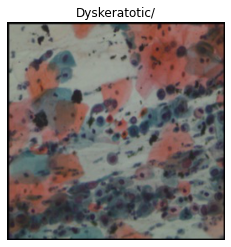

In [ ]:
img = view_random_image(target_dir = "sample_data/CervicalCancer/",target_class='Dyskeratotic/')

Image shape: (260, 260, 3)


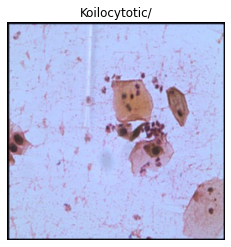

In [ ]:
img = view_random_image(target_dir = "sample_data/CervicalCancer/",target_class='Koilocytotic/')

Image shape: (260, 260, 3)


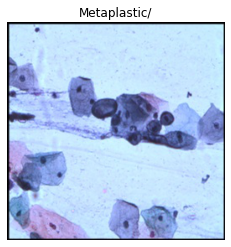

In [ ]:
img = view_random_image(target_dir = "sample_data/CervicalCancer/",target_class='Metaplastic/')

Image shape: (260, 260, 3)


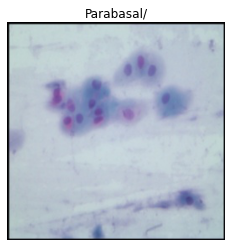

In [ ]:
img = view_random_image(target_dir = "sample_data/CervicalCancer/",target_class='Parabasal/')

Image shape: (260, 260, 3)


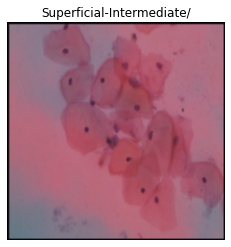

In [ ]:
img = view_random_image(target_dir = "sample_data/CervicalCancer/",target_class='Superficial-Intermediate/')

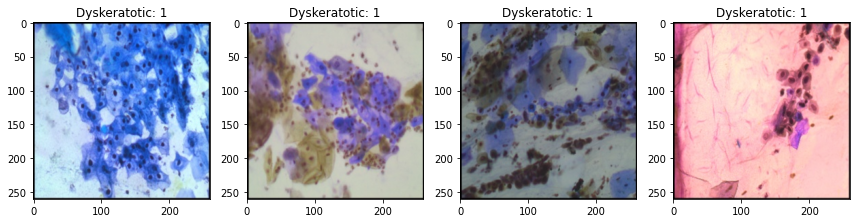

In [ ]:
#Class- Dyskeratotic (abnormal)
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1,4,i+1)
    img = cv2.imread('sample_data/CervicalCancer/Dyskeratotic/' + "/" + dys_data[i])
    plt.imshow(img)
    plt.title('Dyskeratotic: 1')
    plt.tight_layout()
plt.show()

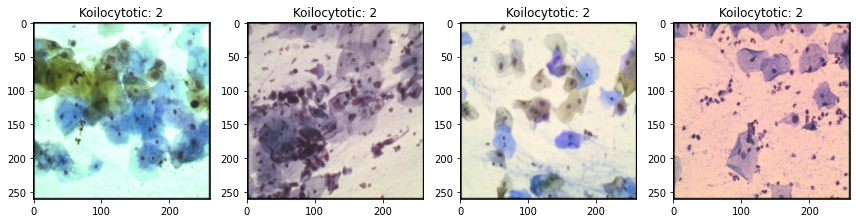

In [ ]:
#Class- Koilocytotic (abnormal)
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1,4,i+1)
    img = cv2.imread('sample_data/CervicalCancer/Koilocytotic/' + "/" + koi_data[i])
    plt.imshow(img)
    plt.title('Koilocytotic: 2')
    plt.tight_layout()
plt.show()

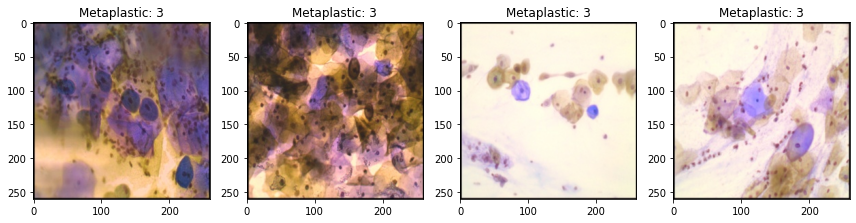

In [ ]:
#Class- Metaplastic (benign)
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1,4,i+1)
    img = cv2.imread('sample_data/CervicalCancer/Metaplastic/' + "/" + met_data[i])
    plt.imshow(img)
    plt.title('Metaplastic: 3')
    plt.tight_layout()
plt.show()

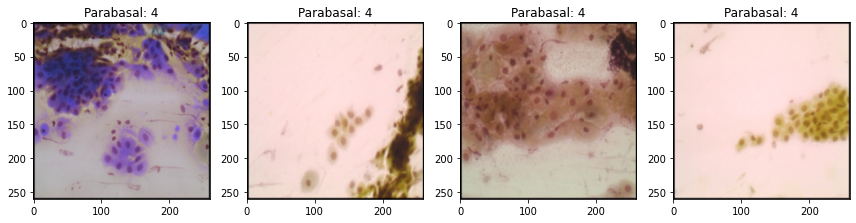

In [ ]:
#Class- Parabasal (normal)
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1,4,i+1)
    img = cv2.imread('sample_data/CervicalCancer/Parabasal/' + "/" + par_data[i])
    plt.imshow(img)
    plt.title('Parabasal: 4')
    plt.tight_layout()
plt.show()

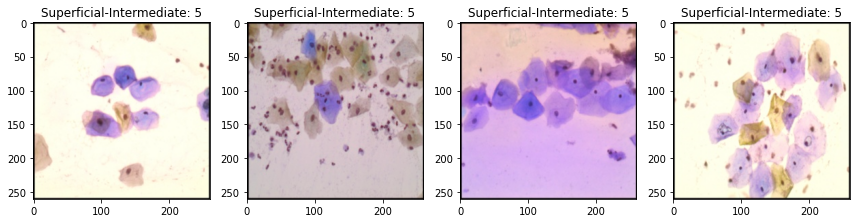

In [ ]:
#Class- Superficial-Intermediate (normal)
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1,4,i+1)
    img = cv2.imread('sample_data/CervicalCancer/Superficial-Intermediate/' + "/" + sup_data[i])
    plt.imshow(img)
    plt.title('Superficial-Intermediate: 5')
    plt.tight_layout()
plt.show()

Inference: The image shape shows a tuple of (row (height), column (width), color (3)) which is (260,260,3). The data visualization shows that Dyskeratotic and Koilocytotic groups are considered abnormal, Metaplastic is considered Benign, and Parabasal and Superficial-Intermediate are considered normal.

### Applying Pre-trained Models over Original Images

In [ ]:
def TrainTestValSplit(root_dir, classes_dir, val_ratio = 0.1, test_ratio = 0.1):
    for cls in classes_dir:
        #Creating separate folders
        os.makedirs('sample_data/train_org/' + cls)
        os.makedirs('sample_data/test_org/' + cls)
        os.makedirs('sample_data/val_org/' + cls)
        
        src = os.path.join(root_dir, cls)

        #Spliting the image files in the given ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]

        #To display the split details
        print(cls,':')
        print('Total Images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Testing: ', len(test_FileNames))
        print('Validation: ', len(val_FileNames))
        
        for name in train_FileNames:
            shutil.copy(name, 'sample_data/train_org/' + cls)
        for name in test_FileNames:
            shutil.copy(name, 'sample_data/test_org/' + cls)
        for name in val_FileNames:
            shutil.copy(name, 'sample_data/val_org/' + cls)

        print()

root_dir = "./sample_data/CervicalCancer"
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]
TrainTestValSplit(root_dir, classes)

Dyskeratotic :
Total Images:  223
Training:  178
Testing:  23
Validation:  22

Koilocytotic :
Total Images:  238
Training:  190
Testing:  24
Validation:  24

Metaplastic :
Total Images:  271
Training:  216
Testing:  28
Validation:  27

Parabasal :
Total Images:  108
Training:  86
Testing:  11
Validation:  11

Superficial-Intermediate :
Total Images:  126
Training:  100
Testing:  13
Validation:  13



In [ ]:
train_org_dir = "sample_data/train_org/"
test_org_dir = "sample_data/test_org/"
val_org_dir = "sample_data/val_org/"

#Rescaling
train_org = ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2, rescale = 1./255, horizontal_flip=True)
test_org = ImageDataGenerator(rescale = 1./255)
val_org = ImageDataGenerator(rescale = 1./255)

#Transfer the data from directories to batches
train_org_data = train_org.flow_from_directory(directory = train_org_dir,
                                               batch_size= 32,
                                               target_size= (256,256),
                                               class_mode = "categorical")

train_org_data.class_indices

Found 770 images belonging to 5 classes.


{'Dyskeratotic': 0,
 'Koilocytotic': 1,
 'Metaplastic': 2,
 'Parabasal': 3,
 'Superficial-Intermediate': 4}

In [ ]:
test_org_data = test_org.flow_from_directory(directory = test_org_dir,
                                               batch_size = 32,
                                               target_size = (256,256),
                                               class_mode = "categorical")

val_org_data = val_org.flow_from_directory(directory = val_org_dir,
                                               batch_size = 32,
                                               target_size = (256,256),
                                               class_mode = "categorical")

Found 99 images belonging to 5 classes.
Found 97 images belonging to 5 classes.


#### Using ResNet50 Model

In [ ]:
base_model = ResNet50(input_shape=(256,256,3),
                      include_top=False,)

for layer in base_model.layers:
       layer.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
model_resnet = Sequential()
model_resnet.add(base_model)
model_resnet.add(layers.Dropout(0.25))
model_resnet.add(layers.Flatten())
model_resnet.add(layers.Dropout(0.5))
model_resnet.add(layers.Dense(5, activation='softmax'))

In [ ]:
model_resnet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 8, 8, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dropout_1 (Dropout)         (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 5)                 655365    
                                                                 
Total params: 24,243,077
Trainable params: 655,365
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_resnet_org_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
resnet = model_resnet.fit(
    train_org_data, 
    steps_per_epoch = len(train_org_data), 
    epochs = 5, 
    validation_data = val_org_data, 
    validation_steps = len(val_org_data),
    callbacks = call_back 
    )

Epoch 1/5
25/25 [==============================] - 30s 647ms/step - loss: 22.0215 - accuracy: 0.2338 - precision: 0.2339 - recall: 0.2312 - val_loss: 11.9184 - val_accuracy: 0.2268 - val_precision: 0.2268 - val_recall: 0.2268
Epoch 2/5
25/25 [==============================] - 13s 534ms/step - loss: 8.8513 - accuracy: 0.2468 - precision: 0.2474 - recall: 0.2429 - val_loss: 8.3656 - val_accuracy: 0.2784 - val_precision: 0.2708 - val_recall: 0.2680
Epoch 3/5
25/25 [==============================] - 13s 533ms/step - loss: 7.7077 - accuracy: 0.2870 - precision: 0.2899 - recall: 0.2831 - val_loss: 7.0521 - val_accuracy: 0.3196 - val_precision: 0.3226 - val_recall: 0.3093
Epoch 4/5
25/25 [==============================] - 13s 536ms/step - loss: 5.9094 - accuracy: 0.2805 - precision: 0.2799 - recall: 0.2675 - val_loss: 4.2741 - val_accuracy: 0.2680 - val_precision: 0.2604 - val_recall: 0.2577
Epoch 5/5
25/25 [==============================] - 13s 506ms/step - loss: 6.0518 - accuracy: 0.3130 - 

In [ ]:
#Loading the best fit model
resnet_model = load_model("./oc_resnet_org_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_resnet_org = resnet_model.evaluate_generator(generator= test_org_data)[1]
precision_resnet_org = resnet_model.evaluate_generator(generator= test_org_data)[2]
recall_resnet_org = resnet_model.evaluate_generator(generator= test_org_data)[3]
print(f"Accuracy = {accuracy_resnet_org*100} %")
print(f"Precision = {precision_resnet_org*100} %")
print(f"Recall = {recall_resnet_org*100} %")

<ipython-input-22-c0aefe10376c>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_resnet_org = resnet_model.evaluate_generator(generator= test_org_data)[1]
<ipython-input-22-c0aefe10376c>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_resnet_org = resnet_model.evaluate_generator(generator= test_org_data)[2]
<ipython-input-22-c0aefe10376c>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_resnet_org = resnet_model.evaluate_generator(generator= test_org_data)[3]


Accuracy = 29.29292917251587 %
Precision = 29.29292917251587 %
Recall = 29.29292917251587 %


#### Using VGG16 Model

In [ ]:
model_VGG = VGG16(
    input_shape = (256,256,3),
    include_top = False
    )

for layer in model_VGG.layers:
       layer.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
vgg16 = Sequential()
vgg16.add(model_VGG)
vgg16.add(layers.Dropout(0.25))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.5))
vgg16.add(layers.Dense(5, activation='softmax'))

In [ ]:
vgg16.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 dropout_2 (Dropout)         (None, 8, 8, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_3 (Dropout)         (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 5)                 163845    
                                                                 
Total params: 14,878,533
Trainable params: 163,845
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_vgg_org_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
vgg = vgg16.fit(
    train_org_data,
    steps_per_epoch = train_org_data.samples//train_org_data.batch_size, 
    epochs = 5, 
    validation_data = val_org_data, 
    validation_steps = val_org_data.samples//val_org_data.batch_size,
    callbacks=call_back
)

Epoch 1/5
24/24 [==============================] - 19s 602ms/step - loss: 3.1193 - accuracy: 0.3672 - precision: 0.3672 - recall: 0.3333 - val_loss: 1.6520 - val_accuracy: 0.5625 - val_precision: 0.5814 - val_recall: 0.5208
Epoch 2/5
24/24 [==============================] - 14s 562ms/step - loss: 1.3171 - accuracy: 0.6003 - precision: 0.6209 - recall: 0.5637 - val_loss: 1.0125 - val_accuracy: 0.6458 - val_precision: 0.6786 - val_recall: 0.5938
Epoch 3/5
24/24 [==============================] - 13s 530ms/step - loss: 0.9306 - accuracy: 0.6748 - precision: 0.7056 - recall: 0.6463 - val_loss: 1.0595 - val_accuracy: 0.6354 - val_precision: 0.6556 - val_recall: 0.6146
Epoch 4/5
24/24 [==============================] - 13s 544ms/step - loss: 0.8812 - accuracy: 0.7033 - precision: 0.7285 - recall: 0.6653 - val_loss: 0.7982 - val_accuracy: 0.7396 - val_precision: 0.7442 - val_recall: 0.6667
Epoch 5/5
24/24 [==============================] - 13s 578ms/step - loss: 0.7774 - accuracy: 0.7276 - pr

In [ ]:
#Loading the best fit model
modelVGG = load_model("./oc_vgg_org_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_vgg_org = modelVGG.evaluate_generator(generator= test_org_data)[1]
precision_vgg_org = modelVGG.evaluate_generator(generator= test_org_data)[2]
recall_vgg_org = modelVGG.evaluate_generator(generator= test_org_data)[3]
print(f"Accuracy = {accuracy_vgg_org*100} %")
print(f"Precision = {precision_vgg_org*100} %")
print(f"Recall = {recall_vgg_org*100} %")

<ipython-input-29-1a834e9639e2>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_vgg_org = modelVGG.evaluate_generator(generator= test_org_data)[1]
<ipython-input-29-1a834e9639e2>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_vgg_org = modelVGG.evaluate_generator(generator= test_org_data)[2]
<ipython-input-29-1a834e9639e2>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_vgg_org = modelVGG.evaluate_generator(generator= test_org_data)[3]


Accuracy = 75.75757503509521 %
Precision = 78.88888716697693 %
Recall = 71.71717286109924 %


#### Using VGG19 Model

In [ ]:
model_VGG = VGG19(
    input_shape = (256,256,3),
    include_top = False
    )

for layer in model_VGG.layers:
       layer.trainable = False

80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
vgg19 = Sequential()
vgg19.add(model_VGG)
vgg19.add(layers.Dropout(0.25))
vgg19.add(layers.Flatten())
vgg19.add(layers.Dropout(0.5))
vgg19.add(layers.Dense(5, activation='softmax'))

In [ ]:
vgg19.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

vgg19.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 dropout_4 (Dropout)         (None, 8, 8, 512)         0         
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_5 (Dropout)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 5)                 163845    
                                                                 
Total params: 20,188,229
Trainable params: 163,845
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_vgg19_org_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
vgg = vgg19.fit(
    train_org_data,
    steps_per_epoch = train_org_data.samples//train_org_data.batch_size, 
    epochs = 5, 
    validation_data = val_org_data, 
    validation_steps = val_org_data.samples//val_org_data.batch_size,
    callbacks=call_back
)

Epoch 1/5
24/24 [==============================] - 15s 578ms/step - loss: 2.2669 - accuracy: 0.4219 - precision: 0.4355 - recall: 0.3646 - val_loss: 1.3582 - val_accuracy: 0.5312 - val_precision: 0.6234 - val_recall: 0.5000
Epoch 2/5
24/24 [==============================] - 13s 551ms/step - loss: 1.4839 - accuracy: 0.5352 - precision: 0.5592 - recall: 0.5054 - val_loss: 1.4667 - val_accuracy: 0.4792 - val_precision: 0.4886 - val_recall: 0.4479
Epoch 3/5
24/24 [==============================] - 13s 546ms/step - loss: 1.2215 - accuracy: 0.5921 - precision: 0.6226 - recall: 0.5610 - val_loss: 1.1793 - val_accuracy: 0.5833 - val_precision: 0.6023 - val_recall: 0.5521
Epoch 4/5
24/24 [==============================] - 17s 699ms/step - loss: 1.1125 - accuracy: 0.6369 - precision: 0.6691 - recall: 0.6138 - val_loss: 1.1765 - val_accuracy: 0.6250 - val_precision: 0.6512 - val_recall: 0.5833
Epoch 5/5
24/24 [==============================] - 14s 583ms/step - loss: 0.8436 - accuracy: 0.7019 - pr

In [ ]:
#Loading the best fit model
modelVGG19 = load_model("./oc_vgg19_org_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_vgg19_org = modelVGG19.evaluate_generator(generator= test_org_data)[1]
precision_vgg19_org = modelVGG19.evaluate_generator(generator= test_org_data)[2]
recall_vgg19_org = modelVGG19.evaluate_generator(generator= test_org_data)[3]
print(f"Accuracy = {accuracy_vgg19_org*100} %")
print(f"Precision = {precision_vgg19_org*100} %")
print(f"Recall = {recall_vgg19_org*100} %")

<ipython-input-36-ccac99d9fbee>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_vgg19_org = modelVGG19.evaluate_generator(generator= test_org_data)[1]
<ipython-input-36-ccac99d9fbee>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_vgg19_org = modelVGG19.evaluate_generator(generator= test_org_data)[2]
<ipython-input-36-ccac99d9fbee>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_vgg19_org = modelVGG19.evaluate_generator(generator= test_org_data)[3]


Accuracy = 58.58585834503174 %
Precision = 63.333332538604736 %
Recall = 57.575756311416626 %


#### Using DenseNet121 Model

In [ ]:
model_densenet121 = DenseNet121(
    input_shape = (256,256,3),
    include_top = False
    )

for layer in model_densenet121.layers:
       layer.trainable = False

29084464/29084464 [==============================] - 1s 0us/step


In [ ]:
densenet121 = tf.keras.Sequential()
densenet121.add(model_densenet121)
densenet121.add(layers.Dropout(0.25))
densenet121.add(layers.Flatten())
densenet121.add(layers.Dropout(0.5))
densenet121.add(layers.Dense(5, activation='softmax'))

In [ ]:
densenet121.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

densenet121.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 dropout (Dropout)           (None, 8, 8, 1024)        0         
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dropout_1 (Dropout)         (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 5)                 327685    
                                                                 
Total params: 7,365,189
Trainable params: 327,685
Non-trainable params: 7,037,504
_________________________________________________________________


In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_densenet121_org_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
densenet = densenet121.fit(
    train_org_data,
    steps_per_epoch = train_org_data.samples//train_org_data.batch_size, 
    epochs = 5, 
    validation_data = val_org_data, 
    validation_steps = val_org_data.samples//val_org_data.batch_size,
    callbacks=call_back
)

Epoch 1/5
24/24 [==============================] - 218s 9s/step - loss: 6.0113 - accuracy: 0.4743 - precision: 0.4814 - recall: 0.4729 - val_loss: 1.4397 - val_accuracy: 0.7917 - val_precision: 0.7917 - val_recall: 0.7917
Epoch 2/5
24/24 [==============================] - 214s 9s/step - loss: 1.9843 - accuracy: 0.7588 - precision: 0.7578 - recall: 0.7547 - val_loss: 1.8606 - val_accuracy: 0.7917 - val_precision: 0.7917 - val_recall: 0.7917
Epoch 3/5
24/24 [==============================] - 212s 9s/step - loss: 1.2489 - accuracy: 0.8035 - precision: 0.8065 - recall: 0.8022 - val_loss: 1.2999 - val_accuracy: 0.8333 - val_precision: 0.8421 - val_recall: 0.8333
Epoch 4/5
24/24 [==============================] - 227s 9s/step - loss: 1.0724 - accuracy: 0.8198 - precision: 0.8218 - recall: 0.8184 - val_loss: 1.1057 - val_accuracy: 0.8333 - val_precision: 0.8333 - val_recall: 0.8333
Epoch 5/5
24/24 [==============================] - 208s 9s/step - loss: 1.7537 - accuracy: 0.7778 - precision: 0

In [ ]:
#Loading the best fit model
modeldensenet121 = load_model("./oc_densenet121_org_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_densenet121_org = modeldensenet121.evaluate_generator(generator= test_org_data)[1]
precision_densenet121_org = modeldensenet121.evaluate_generator(generator= test_org_data)[2]
recall_densenet121_org = modeldensenet121.evaluate_generator(generator= test_org_data)[3]
print(f"Accuracy = {accuracy_densenet121_org*100} %")
print(f"Precision = {precision_densenet121_org*100} %")
print(f"Recall = {recall_densenet121_org*100} %")

<ipython-input-20-f365a3fe878f>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_densenet121_org = modeldensenet121.evaluate_generator(generator= test_org_data)[1]
<ipython-input-20-f365a3fe878f>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_densenet121_org = modeldensenet121.evaluate_generator(generator= test_org_data)[2]
<ipython-input-20-f365a3fe878f>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_densenet121_org = modeldensenet121.evaluate_generator(generator= test_org_data)[3]


Accuracy = 77.77777910232544 %
Precision = 77.77777910232544 %
Recall = 77.77777910232544 %


#### Using DenseNet201 Model

In [ ]:
model_densenet = DenseNet201(
    input_shape = (256,256,3),
    include_top = False
    )

for layer in model_densenet.layers:
       layer.trainable = False

74836368/74836368 [==============================] - 4s 0us/step


In [ ]:
densenet201 = Sequential()
densenet201.add(model_densenet)
densenet201.add(layers.Dropout(0.25))
densenet201.add(layers.Flatten())
densenet201.add(layers.Dropout(0.5))
densenet201.add(layers.Dense(5, activation='softmax'))

In [ ]:
densenet201.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

densenet201.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 dropout_8 (Dropout)         (None, 8, 8, 1920)        0         
                                                                 
 flatten_4 (Flatten)         (None, 122880)            0         
                                                                 
 dropout_9 (Dropout)         (None, 122880)            0         
                                                                 
 dense_4 (Dense)             (None, 5)                 614405    
                                                                 
Total params: 18,936,389
Trainable params: 614,405
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_densenet_org_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
densenet = densenet201.fit(
    train_org_data,
    steps_per_epoch = train_org_data.samples//train_org_data.batch_size, 
    epochs = 5, 
    validation_data = val_org_data, 
    validation_steps = val_org_data.samples//val_org_data.batch_size,
    callbacks=call_back
)

Epoch 1/5
24/24 [==============================] - 34s 838ms/step - loss: 7.7617 - accuracy: 0.5081 - precision: 0.5117 - recall: 0.5027 - val_loss: 2.1039 - val_accuracy: 0.7604 - val_precision: 0.7604 - val_recall: 0.7604
Epoch 2/5
24/24 [==============================] - 16s 678ms/step - loss: 1.8806 - accuracy: 0.8125 - precision: 0.8133 - recall: 0.8112 - val_loss: 1.6509 - val_accuracy: 0.8125 - val_precision: 0.8125 - val_recall: 0.8125
Epoch 3/5
24/24 [==============================] - 13s 539ms/step - loss: 0.9973 - accuracy: 0.8686 - precision: 0.8733 - recall: 0.8686 - val_loss: 1.9570 - val_accuracy: 0.7604 - val_precision: 0.7604 - val_recall: 0.7604
Epoch 4/5
24/24 [==============================] - 15s 618ms/step - loss: 1.1085 - accuracy: 0.8469 - precision: 0.8469 - recall: 0.8469 - val_loss: 1.4588 - val_accuracy: 0.8333 - val_precision: 0.8333 - val_recall: 0.8333
Epoch 5/5
24/24 [==============================] - 14s 560ms/step - loss: 1.3420 - accuracy: 0.8577 - pr

In [ ]:
#Loading the best fit model
modeldensenet = load_model("./oc_densenet_org_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_densenet_org = modeldensenet.evaluate_generator(generator= test_org_data)[1]
precision_densenet_org = modeldensenet.evaluate_generator(generator= test_org_data)[2]
recall_densenet_org = modeldensenet.evaluate_generator(generator= test_org_data)[3]
print(f"Accuracy = {accuracy_densenet_org*100} %")
print(f"Precision = {precision_densenet_org*100} %")
print(f"Recall = {recall_densenet_org*100} %")

<ipython-input-50-aa3836dc302c>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_densenet_org = modeldensenet.evaluate_generator(generator= test_org_data)[1]
<ipython-input-50-aa3836dc302c>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_densenet_org = modeldensenet.evaluate_generator(generator= test_org_data)[2]
<ipython-input-50-aa3836dc302c>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_densenet_org = modeldensenet.evaluate_generator(generator= test_org_data)[3]


Accuracy = 78.78788113594055 %
Precision = 78.78788113594055 %
Recall = 78.78788113594055 %


#### Using InceptionV3 Model

In [ ]:
base_model = InceptionV3(input_shape = (256,256,3), 
                         include_top = False,)

for layer in base_model.layers:
       layer.trainable = False

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation='softmax')(x)

In [ ]:
model_incep = tf.keras.models.Model(base_model.input, x)

model_incep.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.002), 
                    loss = 'categorical_crossentropy', 
                    metrics = ['accuracy', 'Precision', 'Recall'])

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_inception_org_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [mc];

In [ ]:
#Fitting the model
incep = model_incep.fit(
    train_org_data, 
    steps_per_epoch = train_org_data.samples//train_org_data.batch_size, 
    epochs = 5, 
    validation_data = val_org_data, 
    validation_steps = val_org_data.samples//val_org_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/5
24/24 [==============================] - 25s 746ms/step - loss: 139.4786 - accuracy: 0.3537 - precision: 0.3559 - recall: 0.3496 - val_loss: 17.2308 - val_accuracy: 0.5625 - val_precision: 0.5625 - val_recall: 0.5625
Epoch 2/5
24/24 [==============================] - 15s 629ms/step - loss: 12.2732 - accuracy: 0.5163 - precision: 0.5178 - recall: 0.5122 - val_loss: 2.3348 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 0.6250
Epoch 3/5
24/24 [==============================] - 12s 497ms/step - loss: 3.1646 - accuracy: 0.5894 - precision: 0.6048 - recall: 0.5515 - val_loss: 4.4467 - val_accuracy: 0.4062 - val_precision: 0.4062 - val_recall: 0.4062
Epoch 4/5
24/24 [==============================] - 12s 505ms/step - loss: 2.9535 - accuracy: 0.5352 - precision: 0.5433 - recall: 0.5014 - val_loss: 2.4196 - val_accuracy: 0.5208 - val_precision: 0.5263 - val_recall: 0.5208
Epoch 5/5
24/24 [==============================] - 15s 643ms/step - loss: 3.1490 - accuracy: 0.5163 

In [ ]:
#Loading the best fit model
inceptionv3_model = load_model("./oc_inception_org_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_incep_org = inceptionv3_model.evaluate_generator(generator= test_org_data)[1]
precision_incep_org = inceptionv3_model.evaluate_generator(generator= test_org_data)[2]
recall_incep_org = inceptionv3_model.evaluate_generator(generator= test_org_data)[3]
print(f"Accuracy = {accuracy_incep_org*100} %")
print(f"Precision = {precision_incep_org*100} %")
print(f"Recall = {recall_incep_org*100} %")

<ipython-input-57-5fb1ac8bdcbb>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_incep_org = inceptionv3_model.evaluate_generator(generator= test_org_data)[1]
<ipython-input-57-5fb1ac8bdcbb>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_incep_org = inceptionv3_model.evaluate_generator(generator= test_org_data)[2]
<ipython-input-57-5fb1ac8bdcbb>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_incep_org = inceptionv3_model.evaluate_generator(generator= test_org_data)[3]


Accuracy = 53.535354137420654 %
Precision = 53.60824465751648 %
Recall = 52.52525210380554 %


#### Using Xception Model

In [ ]:
base_model = Xception(input_shape=(256,256,3),
                      include_top=False,)

for layer in base_model.layers:
       layer.trainable = False

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
model_xception = Sequential()
model_xception.add(base_model)
model_xception.add(layers.Dropout(0.25))
model_xception.add(layers.Flatten())
model_xception.add(layers.Dropout(0.5))
model_xception.add(layers.Dense(5, activation='softmax'))

In [ ]:
model_xception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model_xception.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 dropout_11 (Dropout)        (None, 8, 8, 2048)        0         
                                                                 
 flatten_6 (Flatten)         (None, 131072)            0         
                                                                 
 dropout_12 (Dropout)        (None, 131072)            0         
                                                                 
 dense_7 (Dense)             (None, 5)                 655365    
                                                                 
Total params: 21,516,845
Trainable params: 655,365
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_xception_org_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
xception = model_xception.fit(
    train_org_data, 
    steps_per_epoch = len(train_org_data), 
    epochs = 5, 
    validation_data = val_org_data, 
    validation_steps = len(val_org_data),
    callbacks = call_back 
    )

Epoch 1/5
25/25 [==============================] - 21s 675ms/step - loss: 6.3652 - accuracy: 0.5091 - precision: 0.5204 - recall: 0.4961 - val_loss: 3.1675 - val_accuracy: 0.6082 - val_precision: 0.6146 - val_recall: 0.6082
Epoch 2/5
25/25 [==============================] - 14s 557ms/step - loss: 2.1661 - accuracy: 0.7247 - precision: 0.7277 - recall: 0.7221 - val_loss: 1.4098 - val_accuracy: 0.7938 - val_precision: 0.7938 - val_recall: 0.7938
Epoch 3/5
25/25 [==============================] - 14s 540ms/step - loss: 1.2424 - accuracy: 0.8078 - precision: 0.8118 - recall: 0.8065 - val_loss: 3.1289 - val_accuracy: 0.6186 - val_precision: 0.6316 - val_recall: 0.6186
Epoch 4/5
25/25 [==============================] - 13s 528ms/step - loss: 1.6183 - accuracy: 0.7948 - precision: 0.7943 - recall: 0.7922 - val_loss: 1.4999 - val_accuracy: 0.7629 - val_precision: 0.7634 - val_recall: 0.7320
Epoch 5/5
25/25 [==============================] - 13s 522ms/step - loss: 1.0458 - accuracy: 0.8403 - pr

In [ ]:
#Loading the best fit model
xception_model = load_model("./oc_xception_org_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_xception_org = xception_model.evaluate_generator(generator= test_org_data)[1]
precision_xception_org = xception_model.evaluate_generator(generator= test_org_data)[2]
recall_xception_org = xception_model.evaluate_generator(generator= test_org_data)[3]
print(f"Accuracy = {accuracy_xception_org*100} %")
print(f"Precision = {precision_xception_org*100} %")
print(f"Recall = {recall_xception_org*100} %")

<ipython-input-64-bc987c8cd2b1>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_xception_org = xception_model.evaluate_generator(generator= test_org_data)[1]
<ipython-input-64-bc987c8cd2b1>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_xception_org = xception_model.evaluate_generator(generator= test_org_data)[2]
<ipython-input-64-bc987c8cd2b1>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_xception_org = xception_model.evaluate_generator(generator= test_org_data)[3]


Accuracy = 61.616164445877075 %
Precision = 62.244898080825806 %
Recall = 61.616164445877075 %


### Data Augmentation

In [ ]:
def blur(img):
    return (cv2.blur(img,(5,5)))

datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        preprocessing_function=blur)

In [ ]:
#Data augmentation of Dyskeratotic image class
image_directory = 'sample_data/CervicalCancer/Dyskeratotic/'
dataset = []

my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = io.imread(image_directory + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((256,256))
        dataset.append(np.array(image))

x = np.array(dataset)
j = 0

for batch in datagen.flow(x, batch_size=8,  
                          save_to_dir='sample_data/Augmented/Dyskeratotic', 
                          save_prefix='aug', 
                          save_format='jpeg'):
    j += 1
    if j > i:
        break

In [ ]:
#Data augmentation of Koilocytotic image class
image_directory = 'sample_data/CervicalCancer/Koilocytotic/'
dataset = []

my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = io.imread(image_directory + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((256,256))
        dataset.append(np.array(image))

x = np.array(dataset)
j = 0

for batch in datagen.flow(x, batch_size=8,  
                          save_to_dir='sample_data/Augmented/Koilocytotic', 
                          save_prefix='aug', 
                          save_format='jpeg'):
    j += 1
    if j > i:
        break

In [ ]:
#Data augmentation of Metaplastic image class
image_directory = 'sample_data/CervicalCancer/Metaplastic/'
dataset = []

my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = io.imread(image_directory + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((256,256))
        dataset.append(np.array(image))

x = np.array(dataset)
j = 0

for batch in datagen.flow(x, batch_size=8,  
                          save_to_dir='sample_data/Augmented/Metaplastic', 
                          save_prefix='aug', 
                          save_format='jpeg'):
    j += 1
    if j > i:
        break

In [ ]:
#Data augmentation of Parabasal image class
image_directory = 'sample_data/CervicalCancer/Parabasal/'
dataset = []

my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = io.imread(image_directory + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((256,256))
        dataset.append(np.array(image))

x = np.array(dataset)
j = 0

for batch in datagen.flow(x, batch_size=8,  
                          save_to_dir='sample_data/Augmented/Parabasal', 
                          save_prefix='aug', 
                          save_format='jpeg'):
    j += 1
    if j > i:
        break

In [ ]:
#Data augmentation of Superficial-Intermediate image class
image_directory = 'sample_data/CervicalCancer/Superficial-Intermediate/'
dataset = []

my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):
    if (image_name.split('.')[1] == 'jpg'):
        image = io.imread(image_directory + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((256,256))
        dataset.append(np.array(image))

x = np.array(dataset)
j = 0

for batch in datagen.flow(x, batch_size=8,  
                          save_to_dir='sample_data/Augmented/Superficial-Intermediate', 
                          save_prefix='aug', 
                          save_format='jpeg'):
    j += 1
    if j > i:
        break

In [ ]:
root_dir = "./sample_data/Augmented"
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]

print(GetDatasetSize(root_dir, classes))

{'Dyskeratotic': 1777, 'Koilocytotic': 1888, 'Metaplastic': 2160, 'Parabasal': 836, 'Superficial-Intermediate': 994}


### Split the data into training, testing and validation

In [ ]:
def TrainTestValSplit(root_dir, classes_dir, val_ratio = 0.1, test_ratio = 0.1):
    for cls in classes_dir:
        #Creating separate folders
        os.makedirs('sample_data/train/' + cls)
        os.makedirs('sample_data/test/' + cls)
        os.makedirs('sample_data/val/' + cls)
        
        src = os.path.join(root_dir, cls)

        #Spliting the image files in the given ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]

        #To display the split details
        print(cls,':')
        print('Total Images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Testing: ', len(test_FileNames))
        print('Validation: ', len(val_FileNames))
        
        for name in train_FileNames:
            shutil.copy(name, 'sample_data/train/' + cls)
        for name in test_FileNames:
            shutil.copy(name, 'sample_data/test/' + cls)
        for name in val_FileNames:
            shutil.copy(name, 'sample_data/val/' + cls)

        print()

root_dir = "./sample_data/Augmented"
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]
TrainTestValSplit(root_dir, classes)

Dyskeratotic :
Total Images:  1777
Training:  1421
Testing:  178
Validation:  178

Koilocytotic :
Total Images:  1888
Training:  1510
Testing:  189
Validation:  189

Metaplastic :
Total Images:  2160
Training:  1728
Testing:  216
Validation:  216

Parabasal :
Total Images:  836
Training:  668
Testing:  84
Validation:  84

Superficial-Intermediate :
Total Images:  994
Training:  795
Testing:  100
Validation:  99



In [ ]:
train_dir = "sample_data/train/"
test_dir = "sample_data/test/"
val_dir = "sample_data/val/"

#Rescaling
train = ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2, rescale = 1./255, horizontal_flip=True)
test = ImageDataGenerator(rescale = 1./255)
val = ImageDataGenerator(rescale = 1./255)

#Transfer the data from directories to batches
train_data = train.flow_from_directory(directory = train_dir,
                                               batch_size= 32,
                                               target_size= (256,256),
                                               class_mode = "categorical")

train_data.class_indices

Found 6122 images belonging to 5 classes.


{'Dyskeratotic': 0,
 'Koilocytotic': 1,
 'Metaplastic': 2,
 'Parabasal': 3,
 'Superficial-Intermediate': 4}

In [ ]:
test_data = test.flow_from_directory(directory = test_dir,
                                               batch_size = 32,
                                               target_size = (256,256),
                                               class_mode = "categorical")

val_data = val.flow_from_directory(directory = val_dir,
                                               batch_size = 32,
                                               target_size = (256,256),
                                               class_mode = "categorical")

Found 767 images belonging to 5 classes.
Found 766 images belonging to 5 classes.


### With Regularization and Normalization

#### Using ResNet50 Model

In [ ]:
base_model = ResNet50(input_shape=(256,256,3),
                      include_top=False,)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
model_resnet = Sequential()
model_resnet.add(base_model)
model_resnet.add(layers.Dropout(0.25))
model_resnet.add(layers.Flatten())
model_resnet.add(layers.Dropout(0.5))
model_resnet.add(layers.Dense(5, activation='softmax'))

In [ ]:
#Applying L2 Regularization with Batch Normalization
model_resnet = Sequential()
model_resnet.add(base_model)
model_resnet.add(layers.Dense(64))
model_resnet.add(BatchNormalization())
model_resnet.add(layers.Dropout(0.25))
model_resnet.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_resnet.add(BatchNormalization())
model_resnet.add(layers.Flatten())
model_resnet.add(layers.Dropout(0.5))
model_resnet.add(layers.Dense(5, activation='softmax'))

In [ ]:
model_resnet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 dense_2 (Dense)             (None, 8, 8, 64)          131136    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 64)         256       
 ormalization)                                                   
                                                                 
 dropout_4 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 dense_3 (Dense)             (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                      

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_resnet_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
resnet = model_resnet.fit(
    train_data, 
    steps_per_epoch = len(train_data), 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = len(val_data),
    callbacks = call_back 
    )

Epoch 1/10
192/192 [==============================] - 169s 676ms/step - loss: 2.0704 - accuracy: 0.3873 - precision: 0.5469 - recall: 0.1802 - val_loss: 1947.8314 - val_accuracy: 0.2467 - val_precision: 0.2467 - val_recall: 0.2467
Epoch 2/10
192/192 [==============================] - 125s 649ms/step - loss: 1.7589 - accuracy: 0.4585 - precision: 0.6833 - recall: 0.2414 - val_loss: 5.5763 - val_accuracy: 0.2820 - val_precision: 0.2964 - val_recall: 0.2794
Epoch 3/10
192/192 [==============================] - 123s 638ms/step - loss: 1.7396 - accuracy: 0.4766 - precision: 0.7479 - recall: 0.2592 - val_loss: 1.6672 - val_accuracy: 0.2781 - val_precision: 0.6188 - val_recall: 0.1462
Epoch 4/10
192/192 [==============================] - 123s 639ms/step - loss: 1.6527 - accuracy: 0.5319 - precision: 0.7290 - recall: 0.3247 - val_loss: 2.0797 - val_accuracy: 0.4060 - val_precision: 0.5584 - val_recall: 0.1684
Epoch 5/10
192/192 [==============================] - 122s 636ms/step - loss: 1.5560 

In [ ]:
#Loading the best fit model
resnet_model = load_model("./oc_resnet_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_resnet = resnet_model.evaluate_generator(generator= test_data)[1]
precision_resnet = resnet_model.evaluate_generator(generator= test_data)[2]
recall_resnet = resnet_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_resnet*100} %")
print(f"Precision = {precision_resnet*100} %")
print(f"Recall = {recall_resnet*100} %")

<ipython-input-32-23de1284d58a>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_resnet = resnet_model.evaluate_generator(generator= test_data)[1]
<ipython-input-32-23de1284d58a>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_resnet = resnet_model.evaluate_generator(generator= test_data)[2]
<ipython-input-32-23de1284d58a>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_resnet = resnet_model.evaluate_generator(generator= test_data)[3]


Accuracy = 53.84615659713745 %
Precision = 88.35979104042053 %
Recall = 21.773141622543335 %


In [ ]:
results_df = pd.DataFrame(data=[["ResNet50", (accuracy_resnet*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df

Model  Testing Accuracy %
0  ResNet50           53.846157

#### Using VGG16 Model

In [ ]:
model_VGG = VGG16(
    input_shape = (256,256,3),
    include_top = False
    )

for layer in model_VGG.layers:
       layer.trainable = False

In [ ]:
vgg16 = Sequential()
vgg16.add(model_VGG)
vgg16.add(layers.Dropout(0.25))
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.5))
vgg16.add(layers.Dense(5, activation='softmax'))

In [ ]:
#Applying L2 Regularization with Batch Normalization
vgg16 = Sequential()
vgg16.add(model_VGG)
vgg16.add(layers.Dense(64))
vgg16.add(BatchNormalization())
vgg16.add(layers.Dropout(0.25))
vgg16.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
vgg16.add(BatchNormalization())
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.5))
vgg16.add(layers.Dense(5, activation='softmax'))

In [ ]:
vgg16.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 dense_6 (Dense)             (None, 8, 8, 64)          32832     
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 dense_7 (Dense)             (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                      

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_vgg_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
vgg = vgg16.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/10
191/191 [==============================] - 110s 564ms/step - loss: 1.6401 - accuracy: 0.5678 - precision: 0.5868 - recall: 0.5460 - val_loss: 2.6685 - val_accuracy: 0.4239 - val_precision: 0.4254 - val_recall: 0.4185
Epoch 2/10
191/191 [==============================] - 106s 556ms/step - loss: 1.1621 - accuracy: 0.6851 - precision: 0.7010 - recall: 0.6688 - val_loss: 1.1638 - val_accuracy: 0.6766 - val_precision: 0.6874 - val_recall: 0.6603
Epoch 3/10
191/191 [==============================] - 108s 563ms/step - loss: 1.0093 - accuracy: 0.7138 - precision: 0.7302 - recall: 0.6990 - val_loss: 1.2483 - val_accuracy: 0.6522 - val_precision: 0.6643 - val_recall: 0.6454
Epoch 4/10
191/191 [==============================] - 107s 558ms/step - loss: 0.8400 - accuracy: 0.7394 - precision: 0.7565 - recall: 0.7250 - val_loss: 0.6728 - val_accuracy: 0.7962 - val_precision: 0.8159 - val_recall: 0.7826
Epoch 5/10
191/191 [==============================] - 106s 557ms/step - loss: 0.7187 - a

In [ ]:
#Loading the best fit model
modelVGG = load_model("./oc_vgg_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_vgg = modelVGG.evaluate_generator(generator= test_data)[1]
precision_vgg = modelVGG.evaluate_generator(generator= test_data)[2]
recall_vgg = modelVGG.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_vgg*100} %")
print(f"Precision = {precision_vgg*100} %")
print(f"Recall = {recall_vgg*100} %")

<ipython-input-24-75803743878b>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_vgg = modelVGG.evaluate_generator(generator= test_data)[1]
<ipython-input-24-75803743878b>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_vgg = modelVGG.evaluate_generator(generator= test_data)[2]
<ipython-input-24-75803743878b>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_vgg = modelVGG.evaluate_generator(generator= test_data)[3]


Accuracy = 79.40025925636292 %
Precision = 82.23140239715576 %
Recall = 77.8357207775116 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["VGG16", (accuracy_vgg*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0  ResNet50           53.846157
1     VGG16           79.400259

#### Using VGG19 Model

In [ ]:
model_VGG = VGG19(
    input_shape = (256,256,3),
    include_top = False
    )

for layer in model_VGG.layers:
       layer.trainable = False

In [ ]:
vgg19 = Sequential()
vgg19.add(model_VGG)
vgg19.add(layers.Dropout(0.25))
vgg19.add(layers.Flatten())
vgg19.add(layers.Dropout(0.5))
vgg19.add(layers.Dense(5, activation='softmax'))

In [ ]:
#Applying L2 Regularization with Batch Normalization
vgg19 = Sequential()
vgg19.add(model_VGG)
vgg19.add(layers.Dense(64))
vgg19.add(BatchNormalization())
vgg19.add(layers.Dropout(0.25))
vgg19.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
vgg19.add(BatchNormalization())
vgg19.add(layers.Flatten())
vgg19.add(layers.Dropout(0.5))
vgg19.add(layers.Dense(5, activation='softmax'))

In [ ]:
vgg19.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

vgg19.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 dense_9 (Dense)             (None, 8, 8, 64)          32832     
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 dense_10 (Dense)            (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_7 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                      

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_vgg19_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
vgg = vgg19.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/10
191/191 [==============================] - 112s 572ms/step - loss: 1.7116 - accuracy: 0.5498 - precision: 0.5710 - recall: 0.5248 - val_loss: 1.6587 - val_accuracy: 0.5285 - val_precision: 0.5504 - val_recall: 0.5041
Epoch 2/10
191/191 [==============================] - 110s 574ms/step - loss: 1.2736 - accuracy: 0.6507 - precision: 0.6663 - recall: 0.6309 - val_loss: 3.0270 - val_accuracy: 0.4552 - val_precision: 0.4545 - val_recall: 0.4484
Epoch 3/10
191/191 [==============================] - 108s 564ms/step - loss: 1.0871 - accuracy: 0.6890 - precision: 0.7081 - recall: 0.6686 - val_loss: 1.1892 - val_accuracy: 0.6753 - val_precision: 0.6868 - val_recall: 0.6644
Epoch 4/10
191/191 [==============================] - 110s 577ms/step - loss: 0.9118 - accuracy: 0.7146 - precision: 0.7337 - recall: 0.6918 - val_loss: 1.7113 - val_accuracy: 0.5761 - val_precision: 0.5885 - val_recall: 0.5557
Epoch 5/10
191/191 [==============================] - 109s 569ms/step - loss: 0.8070 - a

In [ ]:
#Loading the best fit model
modelVGG19 = load_model("./oc_vgg19_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[1]
precision_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[2]
recall_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_vgg19*100} %")
print(f"Precision = {precision_vgg19*100} %")
print(f"Recall = {recall_vgg19*100} %")

<ipython-input-31-dd3cb86ce2c9>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[1]
<ipython-input-31-dd3cb86ce2c9>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[2]
<ipython-input-31-dd3cb86ce2c9>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[3]


Accuracy = 81.74706697463989 %
Precision = 83.90646576881409 %
Recall = 79.5306384563446 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["VGG19", (accuracy_vgg19*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0  ResNet50           53.846157
1     VGG16           79.400259
2     VGG19           81.747067

#### Using DenseNet121 Model

In [ ]:
model_densenet121 = DenseNet121(
    input_shape = (256,256,3),
    include_top = False
    )

for layer in model_densenet121.layers:
       layer.trainable = False

29084464/29084464 [==============================] - 1s 0us/step


In [ ]:
densenet121 = tf.keras.Sequential()
densenet121.add(model_densenet121)
densenet121.add(layers.Dropout(0.25))
densenet121.add(layers.Flatten())
densenet121.add(layers.Dropout(0.5))
densenet121.add(layers.Dense(5, activation='softmax'))

In [ ]:
#Applying L2 Regularization with Batch Normalization
densenet121 = tf.keras.Sequential()
densenet121.add(model_densenet121)
densenet121.add(layers.Dense(64))
densenet121.add(BatchNormalization())
densenet121.add(layers.Dropout(0.25))
densenet121.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
densenet121.add(BatchNormalization())
densenet121.add(layers.Flatten())
densenet121.add(layers.Dropout(0.5))
densenet121.add(layers.Dense(5, activation='softmax'))

In [ ]:
densenet121.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

densenet121.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 dense_12 (Dense)            (None, 8, 8, 64)          65600     
                                                                 
 batch_normalization_8 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 dense_13 (Dense)            (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_9 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                      

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_densenet121_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
densenet = densenet121.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/10
191/191 [==============================] - 112s 546ms/step - loss: 1.4209 - accuracy: 0.6432 - precision: 0.6621 - recall: 0.6228 - val_loss: 1.0100 - val_accuracy: 0.7446 - val_precision: 0.7469 - val_recall: 0.7337
Epoch 2/10
191/191 [==============================] - 103s 537ms/step - loss: 0.9334 - accuracy: 0.7649 - precision: 0.7742 - recall: 0.7583 - val_loss: 0.5833 - val_accuracy: 0.8397 - val_precision: 0.8494 - val_recall: 0.8356
Epoch 3/10
191/191 [==============================] - 101s 530ms/step - loss: 0.7541 - accuracy: 0.8016 - precision: 0.8104 - recall: 0.7946 - val_loss: 0.6065 - val_accuracy: 0.8302 - val_precision: 0.8456 - val_recall: 0.8261
Epoch 4/10
191/191 [==============================] - 102s 531ms/step - loss: 0.6452 - accuracy: 0.8230 - precision: 0.8303 - recall: 0.8163 - val_loss: 0.5175 - val_accuracy: 0.8573 - val_precision: 0.8624 - val_recall: 0.8519
Epoch 5/10
191/191 [==============================] - 103s 540ms/step - loss: 0.5769 - a

In [ ]:
#Loading the best fit model
modeldensenet121 = load_model("./oc_densenet121_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[1]
precision_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[2]
recall_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_densenet121*100} %")
print(f"Precision = {precision_densenet121*100} %")
print(f"Recall = {recall_densenet121*100} %")

<ipython-input-38-53625a68bcce>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[1]
<ipython-input-38-53625a68bcce>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[2]
<ipython-input-38-53625a68bcce>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[3]


Accuracy = 88.00521492958069 %
Precision = 88.9480710029602 %
Recall = 87.09256649017334 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["DenseNet121", (accuracy_densenet121*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           53.846157
1        VGG16           79.400259
2        VGG19           81.747067
3  DenseNet121           88.005215

#### Using DenseNet201 Model

In [ ]:
model_densenet = DenseNet201(
    input_shape = (256,256,3),
    include_top = False
    )

for layer in model_densenet.layers:
       layer.trainable = False

74836368/74836368 [==============================] - 3s 0us/step


In [ ]:
densenet201 = Sequential()
densenet201.add(model_densenet)
densenet201.add(layers.Dropout(0.25))
densenet201.add(layers.Flatten())
densenet201.add(layers.Dropout(0.5))
densenet201.add(layers.Dense(5, activation='softmax'))

In [ ]:
#Applying L2 Regularization with Batch Normalization
densenet201 = tf.keras.Sequential()
densenet201.add(model_densenet)
densenet201.add(layers.Dense(64))
densenet201.add(BatchNormalization())
densenet201.add(layers.Dropout(0.25))
densenet201.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
densenet201.add(BatchNormalization())
densenet201.add(layers.Flatten())
densenet201.add(layers.Dropout(0.5))
densenet201.add(layers.Dense(5, activation='softmax'))

In [ ]:
densenet201.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

densenet201.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 dense_15 (Dense)            (None, 8, 8, 64)          122944    
                                                                 
 batch_normalization_10 (Bat  (None, 8, 8, 64)         256       
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 dense_16 (Dense)            (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_11 (Bat  (None, 8, 8, 64)         256       
 chNormalization)                                     

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_densenet_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
densenet = densenet201.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/10
191/191 [==============================] - 132s 627ms/step - loss: 1.3194 - accuracy: 0.6696 - precision: 0.6888 - recall: 0.6552 - val_loss: 1.3263 - val_accuracy: 0.7174 - val_precision: 0.7275 - val_recall: 0.7147
Epoch 2/10
191/191 [==============================] - 109s 569ms/step - loss: 0.8407 - accuracy: 0.7862 - precision: 0.7960 - recall: 0.7791 - val_loss: 0.6007 - val_accuracy: 0.8505 - val_precision: 0.8577 - val_recall: 0.8438
Epoch 3/10
191/191 [==============================] - 109s 573ms/step - loss: 0.6849 - accuracy: 0.8253 - precision: 0.8323 - recall: 0.8197 - val_loss: 0.5443 - val_accuracy: 0.8492 - val_precision: 0.8530 - val_recall: 0.8438
Epoch 4/10
191/191 [==============================] - 110s 571ms/step - loss: 0.6062 - accuracy: 0.8374 - precision: 0.8451 - recall: 0.8333 - val_loss: 0.5749 - val_accuracy: 0.8315 - val_precision: 0.8382 - val_recall: 0.8234
Epoch 5/10
191/191 [==============================] - 111s 579ms/step - loss: 0.4882 - a

In [ ]:
#Loading the best fit model
modeldensenet = load_model("./oc_densenet_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_densenet = modeldensenet.evaluate_generator(generator= test_data)[1]
precision_densenet = modeldensenet.evaluate_generator(generator= test_data)[2]
recall_densenet = modeldensenet.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_densenet*100} %")
print(f"Precision = {precision_densenet*100} %")
print(f"Recall = {recall_densenet*100} %")

<ipython-input-45-d419c4f69c01>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_densenet = modeldensenet.evaluate_generator(generator= test_data)[1]
<ipython-input-45-d419c4f69c01>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_densenet = modeldensenet.evaluate_generator(generator= test_data)[2]
<ipython-input-45-d419c4f69c01>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_densenet = modeldensenet.evaluate_generator(generator= test_data)[3]


Accuracy = 90.61277508735657 %
Precision = 91.09042286872864 %
Recall = 89.30899500846863 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["DenseNet201", (accuracy_densenet*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           53.846157
1        VGG16           79.400259
2        VGG19           81.747067
3  DenseNet121           88.005215
4  DenseNet201           90.612775

#### Using InceptionV3 Model

In [ ]:
input_tensor = Input(shape=(256,256,3))
bn = BatchNormalization()(input_tensor)
base_model = InceptionV3(input_shape = (256,256,3), 
                         include_top = False,)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation='softmax')(x)

In [ ]:
#Applying L2 Regularization with Batch Normalization
x = base_model(bn)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer=l2(2e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation='softmax')(x)

In [ ]:
model_incep = tf.keras.models.Model(input_tensor, x)

model_incep.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.002), 
                    loss = 'categorical_crossentropy', 
                    metrics = ['accuracy', 'Precision', 'Recall'])

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_inception_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [mc];

In [ ]:
#Fitting the model
incep = model_incep.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/10
191/191 [==============================] - 147s 606ms/step - loss: 6.7752 - accuracy: 0.2770 - precision: 0.3130 - recall: 0.0471 - val_loss: 412581.2188 - val_accuracy: 0.2799 - val_precision: 0.2799 - val_recall: 0.2799
Epoch 2/10
191/191 [==============================] - 112s 585ms/step - loss: 1.6539 - accuracy: 0.3851 - precision: 0.5038 - recall: 0.1084 - val_loss: 9.9802 - val_accuracy: 0.4511 - val_precision: 0.4958 - val_recall: 0.4008
Epoch 3/10
191/191 [==============================] - 115s 604ms/step - loss: 1.2999 - accuracy: 0.4586 - precision: 0.5763 - recall: 0.2383 - val_loss: 2.6819 - val_accuracy: 0.3913 - val_precision: 0.4076 - val_recall: 0.3628
Epoch 4/10
191/191 [==============================] - 112s 586ms/step - loss: 1.1507 - accuracy: 0.4798 - precision: 0.6066 - recall: 0.2724 - val_loss: 1.3068 - val_accuracy: 0.5299 - val_precision: 0.5788 - val_recall: 0.3342
Epoch 5/10
191/191 [==============================] - 112s 587ms/step - loss: 1.086

In [ ]:
#Loading the best fit model
inceptionv3_model = load_model("./oc_inception_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_incep = inceptionv3_model.evaluate_generator(generator= test_data)[1]
precision_incep = inceptionv3_model.evaluate_generator(generator= test_data)[2]
recall_incep = inceptionv3_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_incep*100} %")
print(f"Precision = {precision_incep*100} %")
print(f"Recall = {recall_incep*100} %")

<ipython-input-26-3fff43831671>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_incep = inceptionv3_model.evaluate_generator(generator= test_data)[1]
<ipython-input-26-3fff43831671>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_incep = inceptionv3_model.evaluate_generator(generator= test_data)[2]
<ipython-input-26-3fff43831671>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_incep = inceptionv3_model.evaluate_generator(generator= test_data)[3]


Accuracy = 67.5358533859253 %
Precision = 70.40358781814575 %
Recall = 61.40808463096619 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["InceptionV3", (accuracy_incep*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           53.846157
1        VGG16           79.400259
2        VGG19           81.747067
3  DenseNet121           88.005215
4  DenseNet201           90.612775
5  InceptionV3           67.535853

#### Using Xception Model

In [ ]:
base_model = Xception(input_shape=(256,256,3),
                      include_top=False,)

for layer in base_model.layers[:-3]:
       layer.trainable = False

In [ ]:
model_xception = Sequential()
model_xception.add(base_model)
model_xception.add(Flatten())
model_xception.add(Dense(1024, activation='relu'))
model_xception.add(Dropout(0.2))
model_xception.add(Dense(5, activation='softmax'))

In [ ]:
#Applying L2 Regularization with Batch Normalization
model_xception = Sequential()
model_xception.add(base_model)
model_xception.add(layers.Dense(64))
model_xception.add(BatchNormalization())
model_xception.add(layers.Dropout(0.25))
model_xception.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_xception.add(BatchNormalization())
model_xception.add(layers.Flatten())
model_xception.add(layers.Dropout(0.5))
model_xception.add(layers.Dense(5, activation='softmax'))

In [ ]:
model_xception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model_xception.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 dense_22 (Dense)            (None, 8, 8, 64)          131136    
                                                                 
 batch_normalization_22 (Bat  (None, 8, 8, 64)         256       
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 dense_23 (Dense)            (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_23 (Bat  (None, 8, 8, 64)         256       
 chNormalization)                                     

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_xception_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
xception = model_xception.fit(
    train_data, 
    steps_per_epoch = len(train_data), 
    epochs = 10, 
    validation_data = val_data, 
    validation_steps = len(val_data),
    callbacks = call_back 
    )

Epoch 1/10
192/192 [==============================] - 112s 555ms/step - loss: 1.5662 - accuracy: 0.5882 - precision: 0.6112 - recall: 0.5645 - val_loss: 1.0701 - val_accuracy: 0.7402 - val_precision: 0.7507 - val_recall: 0.7311
Epoch 2/10
192/192 [==============================] - 106s 550ms/step - loss: 0.9568 - accuracy: 0.7266 - precision: 0.7458 - recall: 0.7063 - val_loss: 0.8533 - val_accuracy: 0.7611 - val_precision: 0.7863 - val_recall: 0.7493
Epoch 3/10
192/192 [==============================] - 105s 546ms/step - loss: 0.7539 - accuracy: 0.7788 - precision: 0.7977 - recall: 0.7573 - val_loss: 0.4979 - val_accuracy: 0.8512 - val_precision: 0.8725 - val_recall: 0.8394
Epoch 4/10
192/192 [==============================] - 105s 546ms/step - loss: 0.5638 - accuracy: 0.8365 - precision: 0.8509 - recall: 0.8202 - val_loss: 0.5748 - val_accuracy: 0.8512 - val_precision: 0.8628 - val_recall: 0.8460
Epoch 5/10
192/192 [==============================] - 105s 548ms/step - loss: 0.5486 - a

In [ ]:
#Loading the best fit model
xception_model = load_model("./oc_xception_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_xception = xception_model.evaluate_generator(generator= test_data)[1]
precision_xception = xception_model.evaluate_generator(generator= test_data)[2]
recall_xception = xception_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_xception*100} %")
print(f"Precision = {precision_xception*100} %")
print(f"Recall = {recall_xception*100} %")

<ipython-input-64-e3a41b4e3296>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_xception = xception_model.evaluate_generator(generator= test_data)[1]
<ipython-input-64-e3a41b4e3296>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_xception = xception_model.evaluate_generator(generator= test_data)[2]
<ipython-input-64-e3a41b4e3296>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_xception = xception_model.evaluate_generator(generator= test_data)[3]


Accuracy = 88.13559412956238 %
Precision = 89.7711992263794 %
Recall = 86.96219325065613 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["Xception", (accuracy_xception*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           53.846157
1        VGG16           79.400259
2        VGG19           81.747067
3  DenseNet121           88.005215
4  DenseNet201           90.612775
5  InceptionV3           67.535853
6     Xception           88.135594

#### Using Custom CNN Model

In [ ]:
model=Sequential()

#convolution layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#convolution layer
model.add(Conv2D(32,(3,3),activation='relu'))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#convolution layer
model.add(Conv2D(64,(3,3),activation='relu'))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#convolution layer
model.add(Conv2D(64,(3,3),activation='relu'))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#global average pooling
model.add(GlobalAveragePooling2D())
#fully connected layer
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(BatchNormalization())

#output layer
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 127, 127, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                      

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_custom_best_model.hdf5",
    verbose= 0,
    save_best_only= True,
    monitor='val_loss',
    mode='min'
    )
call_back = [mc];

In [ ]:
#Fitting the model
custom = model.fit(
    train_data, 
    steps_per_epoch = len(train_data), 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = len(val_data),
    callbacks = call_back 
    )

Epoch 1/20
192/192 [==============================] - 97s 477ms/step - loss: 0.8741 - accuracy: 0.7025 - precision: 0.7843 - recall: 0.6058 - val_loss: 1.7869 - val_accuracy: 0.2963 - val_precision: 0.3333 - val_recall: 0.1802
Epoch 2/20
192/192 [==============================] - 92s 477ms/step - loss: 0.6509 - accuracy: 0.7818 - precision: 0.8272 - recall: 0.7271 - val_loss: 1.1515 - val_accuracy: 0.6358 - val_precision: 0.6792 - val_recall: 0.5914
Epoch 3/20
192/192 [==============================] - 91s 473ms/step - loss: 0.5286 - accuracy: 0.8291 - precision: 0.8619 - recall: 0.7911 - val_loss: 0.6896 - val_accuracy: 0.7794 - val_precision: 0.7989 - val_recall: 0.7467
Epoch 4/20
192/192 [==============================] - 91s 473ms/step - loss: 0.4761 - accuracy: 0.8460 - precision: 0.8790 - recall: 0.8172 - val_loss: 2.2239 - val_accuracy: 0.5392 - val_precision: 0.5502 - val_recall: 0.5222
Epoch 5/20
192/192 [==============================] - 91s 473ms/step - loss: 0.4376 - accura

In [ ]:
#Loading the best fit model
custom_model = load_model("./oc_custom_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_custom = custom_model.evaluate_generator(generator= test_data)[1]
precision_custom = custom_model.evaluate_generator(generator= test_data)[2]
recall_custom = custom_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_custom*100} %")
print(f"Precision = {precision_custom*100} %")
print(f"Recall = {recall_custom*100} %")

<ipython-input-23-42bba74b5eb6>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_custom = custom_model.evaluate_generator(generator= test_data)[1]
<ipython-input-23-42bba74b5eb6>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_custom = custom_model.evaluate_generator(generator= test_data)[2]
<ipython-input-23-42bba74b5eb6>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_custom = custom_model.evaluate_generator(generator= test_data)[3]


Accuracy = 96.74054980278015 %
Precision = 97.11664319038391 %
Recall = 96.61017060279846 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["Custom", (accuracy_custom*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           53.846157
1        VGG16           79.400259
2        VGG19           81.747067
3  DenseNet121           88.005215
4  DenseNet201           90.612775
5  InceptionV3           67.535853
6     Xception           88.135594
7       Custom           96.740550

In [ ]:
models_test_acc = [accuracy_resnet, accuracy_vgg, accuracy_vgg19, accuracy_densenet121, accuracy_densenet, accuracy_incep, accuracy_xception, accuracy_custom]
accuracy_scores = []
for model in models_test_acc:
    accuracy_scores.append(model)
print(accuracy_scores)

[0.5384615659713745, 0.7940025925636292, 0.8174706697463989, 0.8800521492958069, 0.9061277508735657, 0.675358533859253, 0.8813559412956238, 0.9674054980278015]


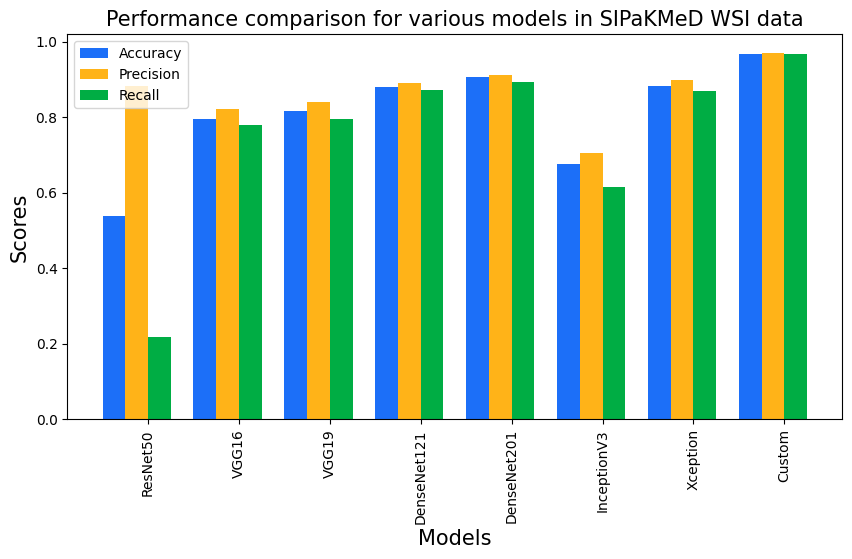

In [ ]:
ind = np.arange(8)
width = 0.25
fig, ax = plt.subplots(figsize=(10,5))

accu = [accuracy_resnet, accuracy_vgg, accuracy_vgg19, accuracy_densenet121, accuracy_densenet, accuracy_incep, accuracy_xception, accuracy_custom]
rects1 = ax.bar(ind, accu, width,color='#1c6ff8')
prec = [precision_resnet, precision_vgg, precision_vgg19, precision_densenet121, precision_densenet, precision_incep, precision_xception, precision_custom]
rects2 = ax.bar(ind+width, prec, width,color='#ffb318')
rec = [recall_resnet, recall_vgg, recall_vgg19, recall_densenet121, recall_densenet, recall_incep, recall_xception, recall_custom]
rects3 = ax.bar(ind + 2 * width, rec, width,color='#00ad44')

ax.set_xlabel('Models', fontsize=15)
ax.set_ylabel('Scores', fontsize=15)
ax.set_title('Performance comparison for various models in SIPaKMeD WSI data', fontsize=15)
ax.set_xticks(ind + 1.5*width)
ax.set_xticklabels(('ResNet50','VGG16','VGG19','DenseNet121','DenseNet201','InceptionV3','Xception','Custom'))
ax.legend((rects1[0], rects2[0], rects3[0]), ('Accuracy', 'Precision', 'Recall'))
plt.xticks(rotation=90)
plt.show()

Inference: It is clear from the barplot that our own custom CNN model shows the highest performance without segmentation.

### Image Segmentation

#### Using Otsu's Thresholding Method

In [ ]:
#Sample image from the dataset to test segmentation
img = plt.imread(root_dir+'/Dyskeratotic/001.jpg')

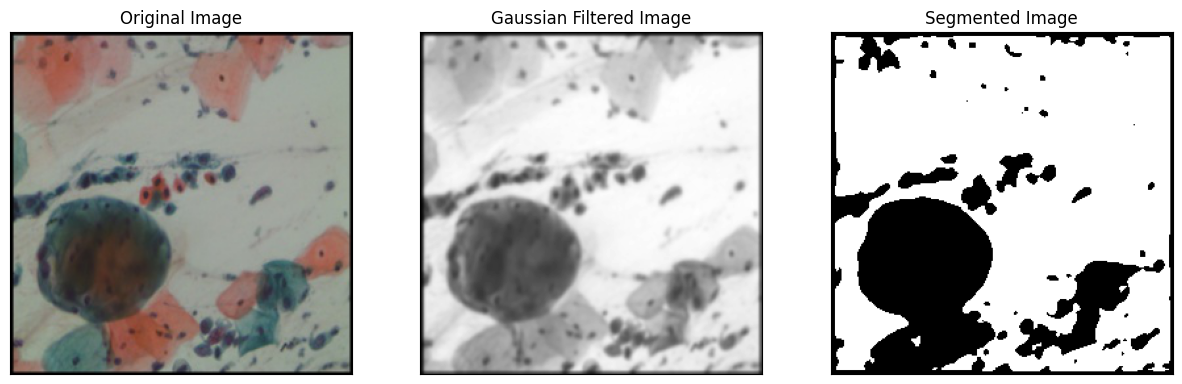

In [ ]:
def segmentation(img):
    #Read the image in grayscale mode
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #Apply GaussianBlur to reduce noise
    blur = cv2.GaussianBlur(gray,(5,5),0)
    #Otsu's thresholding after Gaussian filtering
    ret3, th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #Visualise the images
    plt.figure(figsize=(15,5))
    images = [blur, 0, th3]
    titles = ['Original Image','Gaussian Filtered Image',"Segmented Image"]
    plt.subplot(1,3,1),plt.imshow(img,'gray')
    plt.title(titles[0]), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,2),plt.imshow(images[0],'gray')
    plt.title(titles[1]), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,3),plt.imshow(images[2],'gray')
    plt.title(titles[2]), plt.xticks([]), plt.yticks([])

segmentation(img)

In [ ]:
def image_segmentation(img):
    #Read the image in grayscale mode
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #Apply GaussianBlur to reduce noise
    blur = cv2.GaussianBlur(gray,(5,5),0)
    #Otsu's thresholding after Gaussian filtering
    ret3, th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th3

In [ ]:
def FormatDataset(dataset_src, dataset_dest, classes):
    #Making a copy of dataset
    new_complete_dest = [os.path.join(dataset_dest, cls) for cls in classes]
    complete_src = [ dataset_src + "/" + cls for cls in classes]
    for (dest1) in (new_complete_dest):
        os.makedirs(dest1)
    #Formatting Complete Images
    for (src, new_dest) in zip(complete_src, new_complete_dest):
      for file in os.listdir(src):
        filename, file_ext = os.path.splitext(file)
        img_des = os.path.join(new_dest, filename + '.jpg')
        img = cv2.imread(os.path.join(src, file))
        img = image_segmentation(img)
        cv2.imwrite(img_des, img)

#Source location for dataset
src = './sample_data/Augmented'
#Destination location for dataset
dest = './sample_data/Segmented'
#Image classes
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]
#Formatting dataset
FormatDataset(src, dest, classes)

### Split the segmented data into training, testing and validation

In [ ]:
def TrainTestValSplit(root_dir, classes_dir, val_ratio = 0.1, test_ratio = 0.1):
    for cls in classes_dir:
        #Creating separate folders
        os.makedirs('sample_data/train/' + cls)
        os.makedirs('sample_data/test/' + cls)
        os.makedirs('sample_data/val/' + cls)
        
        src = os.path.join(root_dir, cls)

        #Spliting the image files in the given ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]

        #To display the split details
        print(cls,':')
        print('Total Images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Testing: ', len(test_FileNames))
        print('Validation: ', len(val_FileNames))
        
        for name in train_FileNames:
            shutil.copy(name, 'sample_data/train/' + cls)
        for name in test_FileNames:
            shutil.copy(name, 'sample_data/test/' + cls)
        for name in val_FileNames:
            shutil.copy(name, 'sample_data/val/' + cls)

        print()

root_dir = "./sample_data/Segmented"
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]
TrainTestValSplit(root_dir, classes)

Dyskeratotic :
Total Images:  1777
Training:  1421
Testing:  178
Validation:  178

Koilocytotic :
Total Images:  1888
Training:  1510
Testing:  189
Validation:  189

Metaplastic :
Total Images:  2160
Training:  1728
Testing:  216
Validation:  216

Parabasal :
Total Images:  836
Training:  668
Testing:  84
Validation:  84

Superficial-Intermediate :
Total Images:  994
Training:  795
Testing:  100
Validation:  99



In [ ]:
train_dir = "sample_data/train/"
test_dir = "sample_data/test/"
val_dir = "sample_data/val/"

#Rescaling
train = ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2, rescale = 1./255, horizontal_flip=True)
test = ImageDataGenerator(rescale = 1./255)
val = ImageDataGenerator(rescale = 1./255)

#Transfer the data from directories to batches
train_data = train.flow_from_directory(directory = train_dir,
                                               batch_size= 32,
                                               target_size= (256,256),
                                               class_mode = "categorical")

train_data.class_indices

Found 6122 images belonging to 5 classes.


{'Dyskeratotic': 0,
 'Koilocytotic': 1,
 'Metaplastic': 2,
 'Parabasal': 3,
 'Superficial-Intermediate': 4}

In [ ]:
test_data = test.flow_from_directory(directory = test_dir,
                                               batch_size = 32,
                                               target_size = (256,256),
                                               class_mode = "categorical")

val_data = val.flow_from_directory(directory = val_dir,
                                               batch_size = 32,
                                               target_size = (256,256),
                                               class_mode = "categorical")

Found 767 images belonging to 5 classes.
Found 766 images belonging to 5 classes.


In [ ]:
train_dir = "sample_data/train/"
test_dir = "sample_data/test/"
val_dir = "sample_data/val/"

#Rescaling
train = ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2, rescale = 1./255, horizontal_flip=True)
test = ImageDataGenerator(rescale = 1./255)
val = ImageDataGenerator(rescale = 1./255)

#Transfer the data from directories to batches
train_data = train.flow_from_directory(directory = train_dir,
                                               batch_size= 32,
                                               target_size= (256,256),
                                               class_mode = "categorical")

train_data.class_indices

Found 6122 images belonging to 5 classes.


{'Dyskeratotic': 0,
 'Koilocytotic': 1,
 'Metaplastic': 2,
 'Parabasal': 3,
 'Superficial-Intermediate': 4}

In [ ]:
test_data = test.flow_from_directory(directory = test_dir,
                                               batch_size = 32,
                                               target_size = (256,256),
                                               class_mode = "categorical")

val_data = val.flow_from_directory(directory = val_dir,
                                               batch_size = 32,
                                               target_size = (256,256),
                                               class_mode = "categorical")

Found 767 images belonging to 5 classes.
Found 766 images belonging to 5 classes.


#### Using ResNet50 Model

In [ ]:
base_model = ResNet50(input_shape=(256,256,3),
                      weights='imagenet',
                      include_top=False,)

for layer in base_model.layers:
       layer.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
model_resnet = Sequential()
model_resnet.add(base_model)
model_resnet.add(layers.Dense(64))
model_resnet.add(BatchNormalization())
model_resnet.add(layers.Dropout(0.25))
model_resnet.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_resnet.add(BatchNormalization())
model_resnet.add(layers.Flatten())
model_resnet.add(layers.Dropout(0.5))
model_resnet.add(layers.Dense(5, activation='softmax'))

In [ ]:
model_resnet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 dense_7 (Dense)             (None, 8, 8, 64)          131136    
                                                                 
 batch_normalization_106 (Ba  (None, 8, 8, 64)         256       
 tchNormalization)                                               
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 dense_8 (Dense)             (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_107 (Ba  (None, 8, 8, 64)         256       
 tchNormalization)                                    

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_resnet_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
resnet = model_resnet.fit(
    train_data, 
    steps_per_epoch = len(train_data), 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = len(val_data),
    callbacks = call_back 
    )

Epoch 1/20
192/192 [==============================] - 103s 510ms/step - loss: 2.3973 - accuracy: 0.2806 - precision: 0.2931 - recall: 0.2132 - val_loss: 1.7920 - val_accuracy: 0.2742 - val_precision: 0.3911 - val_recall: 0.1384
Epoch 2/20
192/192 [==============================] - 99s 516ms/step - loss: 1.9724 - accuracy: 0.2893 - precision: 0.3158 - recall: 0.1798 - val_loss: 1.7614 - val_accuracy: 0.3394 - val_precision: 0.3747 - val_recall: 0.1971
Epoch 3/20
192/192 [==============================] - 92s 479ms/step - loss: 1.7799 - accuracy: 0.3130 - precision: 0.3508 - recall: 0.1589 - val_loss: 1.8747 - val_accuracy: 0.3120 - val_precision: 0.3382 - val_recall: 0.2115
Epoch 4/20
192/192 [==============================] - 94s 488ms/step - loss: 1.6991 - accuracy: 0.3231 - precision: 0.3837 - recall: 0.1488 - val_loss: 1.5386 - val_accuracy: 0.3616 - val_precision: 0.5106 - val_recall: 0.0940
Epoch 5/20
192/192 [==============================] - 92s 481ms/step - loss: 1.5890 - accur

In [ ]:
#Loading the best fit model
resnet_model = load_model("./oc_resnet_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_resnet = resnet_model.evaluate_generator(generator= test_data)[1]
precision_resnet = resnet_model.evaluate_generator(generator= test_data)[2]
recall_resnet = resnet_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_resnet*100} %")
print(f"Precision = {precision_resnet*100} %")
print(f"Recall = {recall_resnet*100} %")

<ipython-input-37-23de1284d58a>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_resnet = resnet_model.evaluate_generator(generator= test_data)[1]
<ipython-input-37-23de1284d58a>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_resnet = resnet_model.evaluate_generator(generator= test_data)[2]
<ipython-input-37-23de1284d58a>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_resnet = resnet_model.evaluate_generator(generator= test_data)[3]


Accuracy = 38.85267376899719 %
Precision = 63.01369667053223 %
Recall = 5.997392535209656 %


In [ ]:
results_df = pd.DataFrame(data=[["ResNet50", (accuracy_resnet*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df

Model  Testing Accuracy %
0  ResNet50           38.852674

#### Using VGG16 Model

In [ ]:
model_VGG = VGG16(
    input_shape = (256,256,3),
    weights='imagenet',
    include_top = False
    )

for layer in model_VGG.layers:
       layer.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
vgg16 = Sequential()
vgg16.add(model_VGG)
vgg16.add(layers.Dense(64))
vgg16.add(BatchNormalization())
vgg16.add(layers.Dropout(0.25))
vgg16.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
vgg16.add(BatchNormalization())
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.5))
vgg16.add(layers.Dense(5, activation='softmax'))

In [ ]:
vgg16.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

vgg16.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 dense_10 (Dense)            (None, 8, 8, 64)          32832     
                                                                 
 batch_normalization_108 (Ba  (None, 8, 8, 64)         256       
 tchNormalization)                                               
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 dense_11 (Dense)            (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_109 (Ba  (None, 8, 8, 64)         256       
 tchNormalization)                                    

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_vgg_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
vgg = vgg16.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/20
191/191 [==============================] - 107s 520ms/step - loss: 2.4726 - accuracy: 0.3169 - precision: 0.3261 - recall: 0.2685 - val_loss: 2.7285 - val_accuracy: 0.3057 - val_precision: 0.3100 - val_recall: 0.2948
Epoch 2/20
191/191 [==============================] - 99s 516ms/step - loss: 2.1026 - accuracy: 0.3542 - precision: 0.3705 - recall: 0.2903 - val_loss: 1.9574 - val_accuracy: 0.3859 - val_precision: 0.4326 - val_recall: 0.3139
Epoch 3/20
191/191 [==============================] - 96s 502ms/step - loss: 1.7841 - accuracy: 0.3772 - precision: 0.4068 - recall: 0.2908 - val_loss: 1.5275 - val_accuracy: 0.3750 - val_precision: 0.4504 - val_recall: 0.2405
Epoch 4/20
191/191 [==============================] - 98s 511ms/step - loss: 1.5750 - accuracy: 0.4076 - precision: 0.4644 - recall: 0.2895 - val_loss: 1.4900 - val_accuracy: 0.3872 - val_precision: 0.4791 - val_recall: 0.2649
Epoch 5/20
191/191 [==============================] - 99s 516ms/step - loss: 1.4481 - accur

In [ ]:
#Loading the best fit model
modelVGG = load_model("./oc_vgg_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_vgg = modelVGG.evaluate_generator(generator= test_data)[1]
precision_vgg = modelVGG.evaluate_generator(generator= test_data)[2]
recall_vgg = modelVGG.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_vgg*100} %")
print(f"Precision = {precision_vgg*100} %")
print(f"Recall = {recall_vgg*100} %")

<ipython-input-45-75803743878b>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_vgg = modelVGG.evaluate_generator(generator= test_data)[1]
<ipython-input-45-75803743878b>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_vgg = modelVGG.evaluate_generator(generator= test_data)[2]
<ipython-input-45-75803743878b>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_vgg = modelVGG.evaluate_generator(generator= test_data)[3]


Accuracy = 48.370274901390076 %
Precision = 58.59155058860779 %
Recall = 27.11864411830902 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["VGG16", (accuracy_vgg*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0  ResNet50           38.852674
1     VGG16           48.370275

#### Using VGG19 Model

In [ ]:
model_VGG = VGG19(
    input_shape = (256,256,3),
    weights='imagenet',
    include_top = False
    )

for layer in model_VGG.layers:
       layer.trainable = False

80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
vgg19 = Sequential()
vgg19.add(model_VGG)
vgg19.add(layers.Dense(64))
vgg19.add(BatchNormalization())
vgg19.add(layers.Dropout(0.25))
vgg19.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
vgg19.add(BatchNormalization())
vgg19.add(layers.Flatten())
vgg19.add(layers.Dropout(0.5))
vgg19.add(layers.Dense(5, activation='softmax'))

In [ ]:
vgg19.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

vgg19.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 dense_13 (Dense)            (None, 8, 8, 64)          32832     
                                                                 
 batch_normalization_110 (Ba  (None, 8, 8, 64)         256       
 tchNormalization)                                               
                                                                 
 dropout_7 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 dense_14 (Dense)            (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_111 (Ba  (None, 8, 8, 64)         256       
 tchNormalization)                                    

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_vgg19_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
vgg = vgg19.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/20
191/191 [==============================] - 106s 541ms/step - loss: 2.4459 - accuracy: 0.3220 - precision: 0.3341 - recall: 0.2757 - val_loss: 1.6822 - val_accuracy: 0.3818 - val_precision: 0.4201 - val_recall: 0.2785
Epoch 2/20
191/191 [==============================] - 103s 541ms/step - loss: 2.0855 - accuracy: 0.3493 - precision: 0.3733 - recall: 0.2943 - val_loss: 1.7636 - val_accuracy: 0.3832 - val_precision: 0.4167 - val_recall: 0.2785
Epoch 3/20
191/191 [==============================] - 104s 544ms/step - loss: 1.7695 - accuracy: 0.3755 - precision: 0.4055 - recall: 0.2860 - val_loss: 1.6554 - val_accuracy: 0.3886 - val_precision: 0.4325 - val_recall: 0.2785
Epoch 4/20
191/191 [==============================] - 102s 536ms/step - loss: 1.5939 - accuracy: 0.3982 - precision: 0.4400 - recall: 0.2703 - val_loss: 1.5810 - val_accuracy: 0.3818 - val_precision: 0.4320 - val_recall: 0.2418
Epoch 5/20
191/191 [==============================] - 105s 547ms/step - loss: 1.4507 - a

In [ ]:
#Loading the best fit model
modelVGG19 = load_model("./oc_vgg19_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[1]
precision_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[2]
recall_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_vgg19*100} %")
print(f"Precision = {precision_vgg19*100} %")
print(f"Recall = {recall_vgg19*100} %")

<ipython-input-53-dd3cb86ce2c9>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[1]
<ipython-input-53-dd3cb86ce2c9>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[2]
<ipython-input-53-dd3cb86ce2c9>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[3]


Accuracy = 44.71968710422516 %
Precision = 57.56457448005676 %
Recall = 20.338982343673706 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["VGG19", (accuracy_vgg19*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0  ResNet50           38.852674
1     VGG16           48.370275
2     VGG19           44.719687

#### Using DenseNet121 Model

In [ ]:
model_densenet121 = DenseNet121(
    input_shape = (256,256,3),
    weights='imagenet',
    include_top = False
    )

for layer in model_densenet121.layers:
       layer.trainable = False

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
densenet121 = tf.keras.Sequential()
densenet121.add(model_densenet121)
densenet121.add(layers.Dense(64))
densenet121.add(BatchNormalization())
densenet121.add(layers.Dropout(0.25))
densenet121.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
densenet121.add(BatchNormalization())
densenet121.add(layers.Flatten())
densenet121.add(layers.Dropout(0.5))
densenet121.add(layers.Dense(5, activation='softmax'))

In [ ]:
densenet121.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

densenet121.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 dense_16 (Dense)            (None, 8, 8, 64)          65600     
                                                                 
 batch_normalization_112 (Ba  (None, 8, 8, 64)         256       
 tchNormalization)                                               
                                                                 
 dropout_9 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 dense_17 (Dense)            (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_113 (Ba  (None, 8, 8, 64)         256       
 tchNormalization)                                    

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_densenet121_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
densenet = densenet121.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/20
191/191 [==============================] - 106s 510ms/step - loss: 2.4463 - accuracy: 0.3287 - precision: 0.3403 - recall: 0.2851 - val_loss: 2.5814 - val_accuracy: 0.3492 - val_precision: 0.3677 - val_recall: 0.3152
Epoch 2/20
191/191 [==============================] - 94s 490ms/step - loss: 2.0826 - accuracy: 0.3650 - precision: 0.3921 - recall: 0.3038 - val_loss: 1.6212 - val_accuracy: 0.3995 - val_precision: 0.4512 - val_recall: 0.2704
Epoch 3/20
191/191 [==============================] - 97s 508ms/step - loss: 1.7391 - accuracy: 0.3975 - precision: 0.4355 - recall: 0.3095 - val_loss: 1.4768 - val_accuracy: 0.4334 - val_precision: 0.5032 - val_recall: 0.3220
Epoch 4/20
191/191 [==============================] - 95s 497ms/step - loss: 1.5631 - accuracy: 0.4172 - precision: 0.4759 - recall: 0.3018 - val_loss: 1.3375 - val_accuracy: 0.4688 - val_precision: 0.5710 - val_recall: 0.2840
Epoch 5/20
191/191 [==============================] - 94s 492ms/step - loss: 1.4332 - accur

In [ ]:
#Loading the best fit model
modeldensenet121 = load_model("./oc_densenet121_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[1]
precision_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[2]
recall_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_densenet121*100} %")
print(f"Precision = {precision_densenet121*100} %")
print(f"Recall = {recall_densenet121*100} %")

<ipython-input-61-53625a68bcce>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[1]
<ipython-input-61-53625a68bcce>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[2]
<ipython-input-61-53625a68bcce>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[3]


Accuracy = 45.76271176338196 %
Precision = 57.43440389633179 %
Recall = 25.684484839439392 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["DenseNet121", (accuracy_densenet121*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           38.852674
1        VGG16           48.370275
2        VGG19           44.719687
3  DenseNet121           45.762712

#### Using DenseNet201 Model

In [ ]:
model_densenet = DenseNet201(
    input_shape = (256,256,3),
    weights='imagenet',
    include_top = False
    )

for layer in model_densenet.layers:
       layer.trainable = False

74836368/74836368 [==============================] - 5s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
densenet201 = tf.keras.Sequential()
densenet201.add(model_densenet)
densenet201.add(layers.Dense(64))
densenet201.add(BatchNormalization())
densenet201.add(layers.Dropout(0.25))
densenet201.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
densenet201.add(BatchNormalization())
densenet201.add(layers.Flatten())
densenet201.add(layers.Dropout(0.5))
densenet201.add(layers.Dense(5, activation='softmax'))

In [ ]:
densenet201.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

densenet201.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 dense_19 (Dense)            (None, 8, 8, 64)          122944    
                                                                 
 batch_normalization_114 (Ba  (None, 8, 8, 64)         256       
 tchNormalization)                                               
                                                                 
 dropout_11 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 dense_20 (Dense)            (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_115 (Ba  (None, 8, 8, 64)         256       
 tchNormalization)                                    

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_densenet_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
densenet = densenet201.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/20
191/191 [==============================] - 121s 573ms/step - loss: 2.4413 - accuracy: 0.3312 - precision: 0.3421 - recall: 0.2839 - val_loss: 2.1035 - val_accuracy: 0.3370 - val_precision: 0.3746 - val_recall: 0.2962
Epoch 2/20
191/191 [==============================] - 102s 536ms/step - loss: 2.0561 - accuracy: 0.3701 - precision: 0.3946 - recall: 0.3118 - val_loss: 1.8861 - val_accuracy: 0.3886 - val_precision: 0.4241 - val_recall: 0.3342
Epoch 3/20
191/191 [==============================] - 100s 521ms/step - loss: 1.7330 - accuracy: 0.4007 - precision: 0.4333 - recall: 0.3092 - val_loss: 1.4672 - val_accuracy: 0.4701 - val_precision: 0.5080 - val_recall: 0.3451
Epoch 4/20
191/191 [==============================] - 98s 513ms/step - loss: 1.5374 - accuracy: 0.4187 - precision: 0.4750 - recall: 0.3099 - val_loss: 1.4583 - val_accuracy: 0.4198 - val_precision: 0.4730 - val_recall: 0.3098
Epoch 5/20
191/191 [==============================] - 98s 512ms/step - loss: 1.4053 - acc

In [ ]:
#Loading the best fit model
modeldensenet = load_model("./oc_densenet_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_densenet = modeldensenet.evaluate_generator(generator= test_data)[1]
precision_densenet = modeldensenet.evaluate_generator(generator= test_data)[2]
recall_densenet = modeldensenet.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_densenet*100} %")
print(f"Precision = {precision_densenet*100} %")
print(f"Recall = {recall_densenet*100} %")

<ipython-input-69-d419c4f69c01>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_densenet = modeldensenet.evaluate_generator(generator= test_data)[1]
<ipython-input-69-d419c4f69c01>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_densenet = modeldensenet.evaluate_generator(generator= test_data)[2]
<ipython-input-69-d419c4f69c01>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_densenet = modeldensenet.evaluate_generator(generator= test_data)[3]


Accuracy = 50.065189599990845 %
Precision = 58.83721113204956 %
Recall = 32.98565745353699 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["DenseNet201", (accuracy_densenet*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           38.852674
1        VGG16           48.370275
2        VGG19           44.719687
3  DenseNet121           45.762712
4  DenseNet201           50.065190

#### Using InceptionV3 Model

In [ ]:
input_tensor = Input(shape=(256,256,3))
bn = BatchNormalization()(input_tensor)
base_model = InceptionV3(input_shape = (256,256,3),
                         weights='imagenet',
                         include_top = False,)

for layer in base_model.layers:
       layer.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
x = base_model(bn)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer=l2(2e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation='softmax')(x)

In [ ]:
model_incep = tf.keras.models.Model(input_tensor, x)

model_incep.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.002), 
                    loss = 'categorical_crossentropy', 
                    metrics = ['accuracy', 'Precision', 'Recall'])

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_inception_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [mc];

In [ ]:
#Fitting the model
incep = model_incep.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/20
191/191 [==============================] - 133s 595ms/step - loss: 22.8829 - accuracy: 0.2752 - precision: 0.2759 - recall: 0.0752 - val_loss: 2.0260 - val_accuracy: 0.3329 - val_precision: 0.5135 - val_recall: 0.0258
Epoch 2/20
191/191 [==============================] - 108s 564ms/step - loss: 2.0708 - accuracy: 0.2780 - precision: 0.2586 - recall: 0.0112 - val_loss: 1.7461 - val_accuracy: 0.2880 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
191/191 [==============================] - 109s 570ms/step - loss: 1.7916 - accuracy: 0.2787 - precision: 0.2235 - recall: 0.0066 - val_loss: 1.6214 - val_accuracy: 0.2826 - val_precision: 0.3636 - val_recall: 0.0054
Epoch 4/20
191/191 [==============================] - 109s 570ms/step - loss: 1.7585 - accuracy: 0.2788 - precision: 0.1949 - recall: 0.0062 - val_loss: 1.5866 - val_accuracy: 0.2785 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
191/191 [==============================] - 110s 574ms/step -

In [ ]:
#Loading the best fit model
inceptionv3_model = load_model("./oc_inception_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_incep = inceptionv3_model.evaluate_generator(generator= test_data)[1]
precision_incep = inceptionv3_model.evaluate_generator(generator= test_data)[2]
recall_incep = inceptionv3_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_incep*100} %")
print(f"Precision = {precision_incep*100} %")
print(f"Recall = {recall_incep*100} %")

<ipython-input-12-3fff43831671>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_incep = inceptionv3_model.evaluate_generator(generator= test_data)[1]
<ipython-input-12-3fff43831671>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_incep = inceptionv3_model.evaluate_generator(generator= test_data)[2]
<ipython-input-12-3fff43831671>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_incep = inceptionv3_model.evaluate_generator(generator= test_data)[3]


Accuracy = 28.16166877746582 %
Precision = 0.0 %
Recall = 0.0 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["InceptionV3", (accuracy_incep*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           38.852674
1        VGG16           48.370275
2        VGG19           44.719687
3  DenseNet121           45.762712
4  DenseNet201           50.065190
5  InceptionV3           28.161669

#### Using Xception Model

In [ ]:
base_model = Xception(input_shape=(256,256,3),
                      weights='imagenet',
                      include_top=False,)

for layer in base_model.layers[:-3]:
       layer.trainable = False

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
model_xception = Sequential()
model_xception.add(base_model)
model_xception.add(layers.Dense(64))
model_xception.add(BatchNormalization())
model_xception.add(layers.Dropout(0.25))
model_xception.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_xception.add(BatchNormalization())
model_xception.add(layers.Flatten())
model_xception.add(layers.Dropout(0.5))
model_xception.add(layers.Dense(5, activation='softmax'))

In [ ]:
model_xception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model_xception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 dense_2 (Dense)             (None, 8, 8, 64)          131136    
                                                                 
 batch_normalization_99 (Bat  (None, 8, 8, 64)         256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 dense_3 (Dense)             (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_100 (Ba  (None, 8, 8, 64)         256       
 tchNormalization)                                      

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_xception_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
xception = model_xception.fit(
    train_data, 
    steps_per_epoch = len(train_data), 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = len(val_data),
    callbacks = call_back 
    )

Epoch 1/20
192/192 [==============================] - 115s 565ms/step - loss: 2.3240 - accuracy: 0.3282 - precision: 0.3422 - recall: 0.2525 - val_loss: 2.6786 - val_accuracy: 0.3877 - val_precision: 0.4176 - val_recall: 0.3407
Epoch 2/20
192/192 [==============================] - 101s 525ms/step - loss: 1.9498 - accuracy: 0.3701 - precision: 0.4026 - recall: 0.2537 - val_loss: 1.9768 - val_accuracy: 0.4125 - val_precision: 0.4341 - val_recall: 0.3055
Epoch 3/20
192/192 [==============================] - 101s 526ms/step - loss: 1.7632 - accuracy: 0.4072 - precision: 0.4596 - recall: 0.2450 - val_loss: 1.6124 - val_accuracy: 0.4517 - val_precision: 0.5505 - val_recall: 0.2350
Epoch 4/20
192/192 [==============================] - 101s 526ms/step - loss: 1.5857 - accuracy: 0.4453 - precision: 0.5070 - recall: 0.2607 - val_loss: 1.4966 - val_accuracy: 0.4308 - val_precision: 0.5155 - val_recall: 0.2167
Epoch 5/20
192/192 [==============================] - 101s 527ms/step - loss: 1.4939 - a

In [ ]:
#Loading the best fit model
xception_model = load_model("./oc_xception_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_xception = xception_model.evaluate_generator(generator= test_data)[1]
precision_xception = xception_model.evaluate_generator(generator= test_data)[2]
recall_xception = xception_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_xception*100} %")
print(f"Precision = {precision_xception*100} %")
print(f"Recall = {recall_xception*100} %")

<ipython-input-19-e3a41b4e3296>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_xception = xception_model.evaluate_generator(generator= test_data)[1]
<ipython-input-19-e3a41b4e3296>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_xception = xception_model.evaluate_generator(generator= test_data)[2]
<ipython-input-19-e3a41b4e3296>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_xception = xception_model.evaluate_generator(generator= test_data)[3]


Accuracy = 52.28161811828613 %
Precision = 63.15789222717285 %
Recall = 29.72620725631714 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["Xception", (accuracy_xception*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           38.852674
1        VGG16           48.370275
2        VGG19           44.719687
3  DenseNet121           45.762712
4  DenseNet201           50.065190
5  InceptionV3           28.161669
6     Xception           52.281618

#### Using Custom CNN Model

In [ ]:
model=Sequential()

#convolution layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#convolution layer
model.add(Conv2D(32,(3,3),activation='relu'))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#convolution layer
model.add(Conv2D(64,(3,3),activation='relu'))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#convolution layer
model.add(Conv2D(64,(3,3),activation='relu'))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#global average pooling
model.add(GlobalAveragePooling2D())
#fully connected layer
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(BatchNormalization())

#o/p layer
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model.summary()

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_custom_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
custom = model.fit(
    train_data, 
    steps_per_epoch = len(train_data), 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = len(val_data),
    callbacks = call_back 
    )

Epoch 1/20
192/192 [==============================] - 98s 482ms/step - loss: 1.5165 - accuracy: 0.3664 - precision: 0.4781 - recall: 0.0694 - val_loss: 1.9381 - val_accuracy: 0.1384 - val_precision: 0.4118 - val_recall: 0.0091
Epoch 2/20
192/192 [==============================] - 91s 476ms/step - loss: 1.4494 - accuracy: 0.3876 - precision: 0.5387 - recall: 0.0671 - val_loss: 2.5019 - val_accuracy: 0.2324 - val_precision: 0.2500 - val_recall: 0.2272
Epoch 3/20
192/192 [==============================] - 93s 484ms/step - loss: 1.4413 - accuracy: 0.3868 - precision: 0.5306 - recall: 0.0624 - val_loss: 1.7267 - val_accuracy: 0.3016 - val_precision: 0.3412 - val_recall: 0.1880
Epoch 4/20
192/192 [==============================] - 92s 478ms/step - loss: 1.4118 - accuracy: 0.3946 - precision: 0.5604 - recall: 0.0689 - val_loss: 5.7012 - val_accuracy: 0.1762 - val_precision: 0.1739 - val_recall: 0.1567
Epoch 5/20
192/192 [==============================] - 93s 484ms/step - loss: 1.4039 - accura

In [ ]:
#Loading the best fit model
custom_model = load_model("./oc_custom_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_custom = custom_model.evaluate_generator(generator= test_data)[1]
precision_custom = custom_model.evaluate_generator(generator= test_data)[2]
recall_custom = custom_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_custom*100} %")
print(f"Precision = {precision_custom*100} %")
print(f"Recall = {recall_custom*100} %")

<ipython-input-25-42bba74b5eb6>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_custom = custom_model.evaluate_generator(generator= test_data)[1]
<ipython-input-25-42bba74b5eb6>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_custom = custom_model.evaluate_generator(generator= test_data)[2]
<ipython-input-25-42bba74b5eb6>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_custom = custom_model.evaluate_generator(generator= test_data)[3]


Accuracy = 40.28683304786682 %
Precision = 51.530611515045166 %
Recall = 13.168187439441681 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["Custom", (accuracy_custom*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           38.852674
1        VGG16           48.370275
2        VGG19           44.719687
3  DenseNet121           45.762712
4  DenseNet201           50.065190
5  InceptionV3           28.161669
6     Xception           52.281618
7       Custom           40.286833

#### Using Canny Edge Detection

In [ ]:
#Sample image from the dataset to test segmentation
img = plt.imread(root_dir+'/Koilocytotic/003.jpg')

In [ ]:
#Using Canny Edge Detection method
def canny_edge(img):
    edges = cv2.Canny(img,100,200)
    return edges

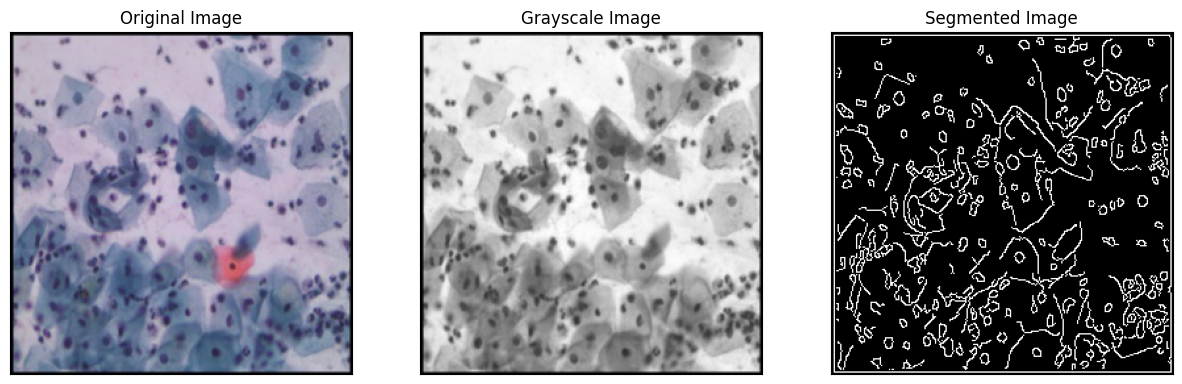

In [ ]:
img = plt.imread(root_dir+'/Koilocytotic/003.jpg')

def canny_segment(img):
  edges=canny_edge(img)
  plt.figure(figsize=(15,5))
  titles = ['Original Image','Grayscale Image',"Segmented Image"]
  plt.subplot(1,3,1),plt.imshow(img)
  plt.title(titles[0]), plt.xticks([]), plt.yticks([])
  plt.subplot(1,3,2),plt.imshow(rgb2gray(img),'gray')
  plt.title(titles[1]), plt.xticks([]), plt.yticks([])
  plt.subplot(1,3,3),plt.imshow(edges,'gray')
  plt.title(titles[2]), plt.xticks([]), plt.yticks([])

canny_segment(img)

In [ ]:
def FormatDataset(dataset_src, dataset_dest, classes):
    new_complete_dest = [os.path.join(dataset_dest, cls) for cls in classes]
    complete_src = [ dataset_src + "/" + cls for cls in classes]
    for (dest1) in (new_complete_dest):
        os.makedirs(dest1)
    #Formatting Segmented Images
    for (src, new_dest) in zip(complete_src, new_complete_dest):
      for file in os.listdir(src):
        filename, file_ext = os.path.splitext(file)
        img_des = os.path.join(new_dest, filename + '.jpg')
        img = cv2.imread(os.path.join(src, file))
        simg = canny_edge(img)
        imsave(img_des,simg)

#Source location for dataset
src = './sample_data/Augmented'
#Destination location for dataset
dest = './sample_data/Segmented'
#Image classes
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]
#Formatting dataset
FormatDataset(src, dest, classes)

<ipython-input-7-6b4c52a09309>:15: UserWarning: ./sample_data/Segmented/Dyskeratotic/aug_185_1028.jpg is a low contrast image
  imsave(img_des,simg)
<ipython-input-7-6b4c52a09309>:15: UserWarning: ./sample_data/Segmented/Dyskeratotic/aug_125_4830.jpg is a low contrast image
  imsave(img_des,simg)
<ipython-input-7-6b4c52a09309>:15: UserWarning: ./sample_data/Segmented/Dyskeratotic/aug_17_4355.jpg is a low contrast image
  imsave(img_des,simg)
<ipython-input-7-6b4c52a09309>:15: UserWarning: ./sample_data/Segmented/Dyskeratotic/aug_125_3997.jpg is a low contrast image
  imsave(img_des,simg)
<ipython-input-7-6b4c52a09309>:15: UserWarning: ./sample_data/Segmented/Dyskeratotic/aug_166_2320.jpg is a low contrast image
  imsave(img_des,simg)
<ipython-input-7-6b4c52a09309>:15: UserWarning: ./sample_data/Segmented/Dyskeratotic/aug_101_4375.jpg is a low contrast image
  imsave(img_des,simg)
<ipython-input-7-6b4c52a09309>:15: UserWarning: ./sample_data/Segmented/Dyskeratotic/aug_166_8156.jpg is a 

### Split the segmented data into training, testing and validation

In [ ]:
def TrainTestValSplit(root_dir, classes_dir, val_ratio = 0.1, test_ratio = 0.1):
    for cls in classes_dir:
        #Creating separate folders
        os.makedirs('sample_data/train/' + cls)
        os.makedirs('sample_data/test/' + cls)
        os.makedirs('sample_data/val/' + cls)
        
        src = os.path.join(root_dir, cls)

        #Spliting the image files in the given ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]

        #To display the split details
        print(cls,':')
        print('Total Images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Testing: ', len(test_FileNames))
        print('Validation: ', len(val_FileNames))
        
        for name in train_FileNames:
            shutil.copy(name, 'sample_data/train/' + cls)
        for name in test_FileNames:
            shutil.copy(name, 'sample_data/test/' + cls)
        for name in val_FileNames:
            shutil.copy(name, 'sample_data/val/' + cls)

        print()

root_dir = "./sample_data/Segmented"
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]
TrainTestValSplit(root_dir, classes)

Dyskeratotic :
Total Images:  1777
Training:  1421
Testing:  178
Validation:  178

Koilocytotic :
Total Images:  1888
Training:  1510
Testing:  189
Validation:  189

Metaplastic :
Total Images:  2160
Training:  1728
Testing:  216
Validation:  216

Parabasal :
Total Images:  836
Training:  668
Testing:  84
Validation:  84

Superficial-Intermediate :
Total Images:  994
Training:  795
Testing:  100
Validation:  99



In [ ]:
train_dir = "sample_data/train/"
test_dir = "sample_data/test/"
val_dir = "sample_data/val/"

#Rescaling
train = ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2, rescale = 1./255, horizontal_flip=True)
test = ImageDataGenerator(rescale = 1./255)
val = ImageDataGenerator(rescale = 1./255)

#Transfer the data from directories to batches
train_data = train.flow_from_directory(directory = train_dir,
                                               batch_size= 32,
                                               target_size= (256,256),
                                               class_mode = "categorical")

train_data.class_indices

Found 6122 images belonging to 5 classes.


{'Dyskeratotic': 0,
 'Koilocytotic': 1,
 'Metaplastic': 2,
 'Parabasal': 3,
 'Superficial-Intermediate': 4}

In [ ]:
test_data = test.flow_from_directory(directory = test_dir,
                                               batch_size = 32,
                                               target_size = (256,256),
                                               class_mode = "categorical")

val_data = val.flow_from_directory(directory = val_dir,
                                               batch_size = 32,
                                               target_size = (256,256),
                                               class_mode = "categorical")

Found 767 images belonging to 5 classes.
Found 766 images belonging to 5 classes.


#### Using ResNet50 Model

In [ ]:
base_model = ResNet50(input_shape=(256,256,3),
                      weights='imagenet',
                      include_top=False,)

for layer in base_model.layers:
       layer.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
model_resnet = Sequential()
model_resnet.add(base_model)
model_resnet.add(layers.Dense(64))
model_resnet.add(BatchNormalization())
model_resnet.add(layers.Dropout(0.25))
model_resnet.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_resnet.add(BatchNormalization())
model_resnet.add(layers.Flatten())
model_resnet.add(layers.Dropout(0.5))
model_resnet.add(layers.Dense(5, activation='softmax'))

In [ ]:
model_resnet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 dense (Dense)               (None, 8, 8, 64)          131136    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 64)         256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 8, 8, 64)          0         
                                                                 
 dense_1 (Dense)             (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                        

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_resnet_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
resnet = model_resnet.fit(
    train_data, 
    steps_per_epoch = len(train_data), 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = len(val_data),
    callbacks = call_back 
    )

Epoch 1/20
192/192 [==============================] - 111s 507ms/step - loss: 2.2958 - accuracy: 0.3169 - precision: 0.3275 - recall: 0.2571 - val_loss: 1.6012 - val_accuracy: 0.3969 - val_precision: 0.4693 - val_recall: 0.2493
Epoch 2/20
192/192 [==============================] - 94s 489ms/step - loss: 1.8407 - accuracy: 0.3376 - precision: 0.3674 - recall: 0.2377 - val_loss: 1.7137 - val_accuracy: 0.3877 - val_precision: 0.4130 - val_recall: 0.3473
Epoch 3/20
192/192 [==============================] - 93s 484ms/step - loss: 1.6509 - accuracy: 0.3564 - precision: 0.4093 - recall: 0.2315 - val_loss: 1.4363 - val_accuracy: 0.3838 - val_precision: 0.4810 - val_recall: 0.1319
Epoch 4/20
192/192 [==============================] - 93s 482ms/step - loss: 1.5266 - accuracy: 0.3747 - precision: 0.4465 - recall: 0.2172 - val_loss: 1.3342 - val_accuracy: 0.4478 - val_precision: 0.5874 - val_recall: 0.1710
Epoch 5/20
192/192 [==============================] - 93s 483ms/step - loss: 1.4482 - accur

In [ ]:
#Loading the best fit model
resnet_model = load_model("./oc_resnet_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_resnet = resnet_model.evaluate_generator(generator= test_data)[1]
precision_resnet = resnet_model.evaluate_generator(generator= test_data)[2]
recall_resnet = resnet_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_resnet*100} %")
print(f"Precision = {precision_resnet*100} %")
print(f"Recall = {recall_resnet*100} %")

<ipython-input-18-23de1284d58a>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_resnet = resnet_model.evaluate_generator(generator= test_data)[1]
<ipython-input-18-23de1284d58a>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_resnet = resnet_model.evaluate_generator(generator= test_data)[2]
<ipython-input-18-23de1284d58a>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_resnet = resnet_model.evaluate_generator(generator= test_data)[3]


Accuracy = 43.02477240562439 %
Precision = 60.28369069099426 %
Recall = 22.164276242256165 %


In [ ]:
results_df = pd.DataFrame(data=[["ResNet50", (accuracy_resnet*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df

Model  Testing Accuracy %
0  ResNet50           43.024772

#### Using VGG16 Model

In [ ]:
model_VGG = VGG16(
    input_shape = (256,256,3),
    weights='imagenet',
    include_top = False
    )

for layer in model_VGG.layers:
       layer.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
vgg16 = Sequential()
vgg16.add(model_VGG)
vgg16.add(layers.Dense(64))
vgg16.add(BatchNormalization())
vgg16.add(layers.Dropout(0.25))
vgg16.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
vgg16.add(BatchNormalization())
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.5))
vgg16.add(layers.Dense(5, activation='softmax'))

In [ ]:
vgg16.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 dense_3 (Dense)             (None, 8, 8, 64)          32832     
                                                                 
 batch_normalization_2 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 dense_4 (Dense)             (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_3 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                      

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_vgg_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
vgg = vgg16.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/20
191/191 [==============================] - 105s 514ms/step - loss: 2.2469 - accuracy: 0.3823 - precision: 0.3992 - recall: 0.3448 - val_loss: 2.3560 - val_accuracy: 0.3125 - val_precision: 0.3179 - val_recall: 0.2418
Epoch 2/20
191/191 [==============================] - 96s 503ms/step - loss: 1.8678 - accuracy: 0.4299 - precision: 0.4551 - recall: 0.3852 - val_loss: 1.4649 - val_accuracy: 0.4810 - val_precision: 0.5383 - val_recall: 0.4293
Epoch 3/20
191/191 [==============================] - 98s 513ms/step - loss: 1.5822 - accuracy: 0.4609 - precision: 0.5012 - recall: 0.4020 - val_loss: 1.5392 - val_accuracy: 0.4552 - val_precision: 0.4991 - val_recall: 0.3954
Epoch 4/20
191/191 [==============================] - 96s 502ms/step - loss: 1.4122 - accuracy: 0.4842 - precision: 0.5334 - recall: 0.3946 - val_loss: 1.5421 - val_accuracy: 0.4606 - val_precision: 0.5209 - val_recall: 0.3560
Epoch 5/20
191/191 [==============================] - 97s 506ms/step - loss: 1.2705 - accur

In [ ]:
#Loading the best fit model
modelVGG = load_model("./oc_vgg_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_vgg = modelVGG.evaluate_generator(generator= test_data)[1]
precision_vgg = modelVGG.evaluate_generator(generator= test_data)[2]
recall_vgg = modelVGG.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_vgg*100} %")
print(f"Precision = {precision_vgg*100} %")
print(f"Recall = {recall_vgg*100} %")

<ipython-input-26-75803743878b>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_vgg = modelVGG.evaluate_generator(generator= test_data)[1]
<ipython-input-26-75803743878b>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_vgg = modelVGG.evaluate_generator(generator= test_data)[2]
<ipython-input-26-75803743878b>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_vgg = modelVGG.evaluate_generator(generator= test_data)[3]


Accuracy = 53.194260597229004 %
Precision = 64.70588445663452 %
Recall = 37.288135290145874 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["VGG16", (accuracy_vgg*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0  ResNet50           43.024772
1     VGG16           53.194261

#### Using VGG19 Model

In [ ]:
model_VGG = VGG19(
    input_shape = (256,256,3),
    weights='imagenet',
    include_top = False
    )

for layer in model_VGG.layers:
       layer.trainable = False

80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
vgg19 = Sequential()
vgg19.add(model_VGG)
vgg19.add(layers.Dense(64))
vgg19.add(BatchNormalization())
vgg19.add(layers.Dropout(0.25))
vgg19.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
vgg19.add(BatchNormalization())
vgg19.add(layers.Flatten())
vgg19.add(layers.Dropout(0.5))
vgg19.add(layers.Dense(5, activation='softmax'))

In [ ]:
vgg19.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

vgg19.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 dense_6 (Dense)             (None, 8, 8, 64)          32832     
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 dense_7 (Dense)             (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                      

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_vgg19_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
vgg = vgg19.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/20
191/191 [==============================] - 102s 519ms/step - loss: 2.3250 - accuracy: 0.3616 - precision: 0.3792 - recall: 0.3225 - val_loss: 2.1918 - val_accuracy: 0.3573 - val_precision: 0.3650 - val_recall: 0.2921
Epoch 2/20
191/191 [==============================] - 101s 526ms/step - loss: 1.9015 - accuracy: 0.4095 - precision: 0.4318 - recall: 0.3568 - val_loss: 2.1147 - val_accuracy: 0.3370 - val_precision: 0.3696 - val_recall: 0.2908
Epoch 3/20
191/191 [==============================] - 100s 522ms/step - loss: 1.6213 - accuracy: 0.4399 - precision: 0.4779 - recall: 0.3750 - val_loss: 1.5559 - val_accuracy: 0.4416 - val_precision: 0.4722 - val_recall: 0.3804
Epoch 4/20
191/191 [==============================] - 100s 525ms/step - loss: 1.4409 - accuracy: 0.4700 - precision: 0.5228 - recall: 0.3706 - val_loss: 1.4040 - val_accuracy: 0.4688 - val_precision: 0.5529 - val_recall: 0.3832
Epoch 5/20
191/191 [==============================] - 99s 516ms/step - loss: 1.3142 - ac

In [ ]:
#Loading the best fit model
modelVGG19 = load_model("./oc_vgg19_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[1]
precision_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[2]
recall_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_vgg19*100} %")
print(f"Precision = {precision_vgg19*100} %")
print(f"Recall = {recall_vgg19*100} %")

<ipython-input-34-dd3cb86ce2c9>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[1]
<ipython-input-34-dd3cb86ce2c9>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[2]
<ipython-input-34-dd3cb86ce2c9>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[3]


Accuracy = 52.41199731826782 %
Precision = 63.14554214477539 %
Recall = 35.071706771850586 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["VGG19", (accuracy_vgg19*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0  ResNet50           43.024772
1     VGG16           53.194261
2     VGG19           52.411997

#### Using DenseNet121 Model

In [ ]:
model_densenet121 = DenseNet121(
    input_shape = (256,256,3),
    weights='imagenet',
    include_top = False
    )

for layer in model_densenet121.layers:
       layer.trainable = False

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
densenet121 = tf.keras.Sequential()
densenet121.add(model_densenet121)
densenet121.add(layers.Dense(64))
densenet121.add(BatchNormalization())
densenet121.add(layers.Dropout(0.25))
densenet121.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
densenet121.add(BatchNormalization())
densenet121.add(layers.Flatten())
densenet121.add(layers.Dropout(0.5))
densenet121.add(layers.Dense(5, activation='softmax'))

In [ ]:
densenet121.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

densenet121.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 dense_9 (Dense)             (None, 8, 8, 64)          65600     
                                                                 
 batch_normalization_6 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 dense_10 (Dense)            (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_7 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                      

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_densenet121_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
densenet = densenet121.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/20
191/191 [==============================] - 104s 505ms/step - loss: 2.2727 - accuracy: 0.3739 - precision: 0.3901 - recall: 0.3304 - val_loss: 2.5018 - val_accuracy: 0.3736 - val_precision: 0.3905 - val_recall: 0.3560
Epoch 2/20
191/191 [==============================] - 92s 479ms/step - loss: 1.8679 - accuracy: 0.4402 - precision: 0.4625 - recall: 0.3883 - val_loss: 1.6182 - val_accuracy: 0.4701 - val_precision: 0.4992 - val_recall: 0.4280
Epoch 3/20
191/191 [==============================] - 95s 494ms/step - loss: 1.5689 - accuracy: 0.4662 - precision: 0.5082 - recall: 0.4054 - val_loss: 1.3032 - val_accuracy: 0.4905 - val_precision: 0.5618 - val_recall: 0.3954
Epoch 4/20
191/191 [==============================] - 94s 490ms/step - loss: 1.3975 - accuracy: 0.4851 - precision: 0.5369 - recall: 0.4049 - val_loss: 1.1902 - val_accuracy: 0.5177 - val_precision: 0.6164 - val_recall: 0.3995
Epoch 5/20
191/191 [==============================] - 94s 494ms/step - loss: 1.2647 - accur

In [ ]:
#Loading the best fit model
modeldensenet121 = load_model("./oc_densenet121_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[1]
precision_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[2]
recall_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_densenet121*100} %")
print(f"Precision = {precision_densenet121*100} %")
print(f"Recall = {recall_densenet121*100} %")

<ipython-input-42-53625a68bcce>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[1]
<ipython-input-42-53625a68bcce>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[2]
<ipython-input-42-53625a68bcce>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[3]


Accuracy = 55.80182671546936 %
Precision = 64.66942429542542 %
Recall = 40.8083438873291 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["DenseNet121", (accuracy_densenet121*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           43.024772
1        VGG16           53.194261
2        VGG19           52.411997
3  DenseNet121           55.801827

#### Using DenseNet201 Model

In [ ]:
model_densenet = DenseNet201(
    input_shape = (256,256,3),
    weights='imagenet',
    include_top = False
    )

for layer in model_densenet.layers:
       layer.trainable = False

74836368/74836368 [==============================] - 4s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
densenet201 = tf.keras.Sequential()
densenet201.add(model_densenet)
densenet201.add(layers.Dense(64))
densenet201.add(BatchNormalization())
densenet201.add(layers.Dropout(0.25))
densenet201.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
densenet201.add(BatchNormalization())
densenet201.add(layers.Flatten())
densenet201.add(layers.Dropout(0.5))
densenet201.add(layers.Dense(5, activation='softmax'))

In [ ]:
densenet201.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

densenet201.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 dense_12 (Dense)            (None, 8, 8, 64)          122944    
                                                                 
 batch_normalization_8 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 dense_13 (Dense)            (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_9 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                      

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_densenet_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
densenet = densenet201.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/20
191/191 [==============================] - 122s 575ms/step - loss: 2.1673 - accuracy: 0.3993 - precision: 0.4132 - recall: 0.3585 - val_loss: 1.9052 - val_accuracy: 0.4606 - val_precision: 0.4850 - val_recall: 0.4185
Epoch 2/20
191/191 [==============================] - 98s 513ms/step - loss: 1.7767 - accuracy: 0.4596 - precision: 0.4889 - recall: 0.4218 - val_loss: 1.8398 - val_accuracy: 0.4633 - val_precision: 0.4902 - val_recall: 0.4416
Epoch 3/20
191/191 [==============================] - 100s 523ms/step - loss: 1.5301 - accuracy: 0.4905 - precision: 0.5232 - recall: 0.4305 - val_loss: 1.5412 - val_accuracy: 0.4891 - val_precision: 0.5205 - val_recall: 0.4321
Epoch 4/20
191/191 [==============================] - 101s 527ms/step - loss: 1.3051 - accuracy: 0.5258 - precision: 0.5700 - recall: 0.4494 - val_loss: 1.6604 - val_accuracy: 0.4524 - val_precision: 0.4866 - val_recall: 0.3696
Epoch 5/20
191/191 [==============================] - 100s 524ms/step - loss: 1.1975 - ac

In [ ]:
#Loading the best fit model
modeldensenet = load_model("./oc_densenet_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_densenet = modeldensenet.evaluate_generator(generator= test_data)[1]
precision_densenet = modeldensenet.evaluate_generator(generator= test_data)[2]
recall_densenet = modeldensenet.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_densenet*100} %")
print(f"Precision = {precision_densenet*100} %")
print(f"Recall = {recall_densenet*100} %")

<ipython-input-50-d419c4f69c01>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_densenet = modeldensenet.evaluate_generator(generator= test_data)[1]
<ipython-input-50-d419c4f69c01>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_densenet = modeldensenet.evaluate_generator(generator= test_data)[2]
<ipython-input-50-d419c4f69c01>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_densenet = modeldensenet.evaluate_generator(generator= test_data)[3]


Accuracy = 54.62841987609863 %
Precision = 60.45694351196289 %
Recall = 44.85006630420685 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["DenseNet201", (accuracy_densenet*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           43.024772
1        VGG16           53.194261
2        VGG19           52.411997
3  DenseNet121           55.801827
4  DenseNet201           54.628420

#### Using InceptionV3 Model

In [ ]:
input_tensor = Input(shape=(256,256,3))
bn = BatchNormalization()(input_tensor)
base_model = InceptionV3(input_shape = (256,256,3),
                         weights='imagenet',
                         include_top = False,)

for layer in base_model.layers:
       layer.trainable = False

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
x = base_model(bn)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer=l2(2e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation='softmax')(x)

In [ ]:
model_incep = tf.keras.models.Model(input_tensor, x)

model_incep.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.002), 
                    loss = 'categorical_crossentropy', 
                    metrics = ['accuracy', 'Precision', 'Recall'])

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_inception_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [mc];

In [ ]:
#Fitting the model
incep = model_incep.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/20
191/191 [==============================] - 137s 604ms/step - loss: 26.5747 - accuracy: 0.3158 - precision: 0.3566 - recall: 0.1172 - val_loss: 1.9942 - val_accuracy: 0.3043 - val_precision: 1.0000 - val_recall: 0.0122
Epoch 2/20
191/191 [==============================] - 106s 555ms/step - loss: 2.0967 - accuracy: 0.3120 - precision: 0.4767 - recall: 0.0453 - val_loss: 5.9897 - val_accuracy: 0.2894 - val_precision: 0.2896 - val_recall: 0.2880
Epoch 3/20
191/191 [==============================] - 105s 549ms/step - loss: 1.8130 - accuracy: 0.3144 - precision: 0.5645 - recall: 0.0402 - val_loss: 5.1876 - val_accuracy: 0.2799 - val_precision: 0.2807 - val_recall: 0.2799
Epoch 4/20
191/191 [==============================] - 108s 566ms/step - loss: 1.7527 - accuracy: 0.3107 - precision: 0.5947 - recall: 0.0402 - val_loss: 1.5070 - val_accuracy: 0.3315 - val_precision: 0.8611 - val_recall: 0.0421
Epoch 5/20
191/191 [==============================] - 108s 564ms/step - loss: 1.6467 - 

In [ ]:
#Loading the best fit model
inceptionv3_model = load_model("./oc_inception_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_incep = inceptionv3_model.evaluate_generator(generator= test_data)[1]
precision_incep = inceptionv3_model.evaluate_generator(generator= test_data)[2]
recall_incep = inceptionv3_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_incep*100} %")
print(f"Precision = {precision_incep*100} %")
print(f"Recall = {recall_incep*100} %")

<ipython-input-12-3fff43831671>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_incep = inceptionv3_model.evaluate_generator(generator= test_data)[1]
<ipython-input-12-3fff43831671>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_incep = inceptionv3_model.evaluate_generator(generator= test_data)[2]
<ipython-input-12-3fff43831671>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_incep = inceptionv3_model.evaluate_generator(generator= test_data)[3]


Accuracy = 33.37679207324982 %
Precision = 80.35714030265808 %
Recall = 5.867014452815056 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["InceptionV3", (accuracy_incep*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           43.024772
1        VGG16           53.194261
2        VGG19           52.411997
3  DenseNet121           55.801827
4  DenseNet201           54.628420
5  InceptionV3           33.376792

#### Using Xception Model

In [ ]:
base_model = Xception(input_shape=(256,256,3),
                      weights='imagenet',
                      include_top=False,)

for layer in base_model.layers[:-3]:
       layer.trainable = False

83683744/83683744 [==============================] - 4s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
model_xception = Sequential()
model_xception.add(base_model)
model_xception.add(layers.Dense(64))
model_xception.add(BatchNormalization())
model_xception.add(layers.Dropout(0.25))
model_xception.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_xception.add(BatchNormalization())
model_xception.add(layers.Flatten())
model_xception.add(layers.Dropout(0.5))
model_xception.add(layers.Dense(5, activation='softmax'))

In [ ]:
model_xception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model_xception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 dense_2 (Dense)             (None, 8, 8, 64)          131136    
                                                                 
 batch_normalization_99 (Bat  (None, 8, 8, 64)         256       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 dense_3 (Dense)             (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_100 (Ba  (None, 8, 8, 64)         256       
 tchNormalization)                                      

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_xception_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
xception = model_xception.fit(
    train_data, 
    steps_per_epoch = len(train_data), 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = len(val_data),
    callbacks = call_back 
    )

Epoch 1/20
192/192 [==============================] - 116s 572ms/step - loss: 2.1886 - accuracy: 0.3723 - precision: 0.3888 - recall: 0.3167 - val_loss: 2.3318 - val_accuracy: 0.4230 - val_precision: 0.4305 - val_recall: 0.3760
Epoch 2/20
192/192 [==============================] - 105s 549ms/step - loss: 1.6692 - accuracy: 0.4471 - precision: 0.4881 - recall: 0.3692 - val_loss: 2.0024 - val_accuracy: 0.4543 - val_precision: 0.4783 - val_recall: 0.4164
Epoch 3/20
192/192 [==============================] - 104s 541ms/step - loss: 1.4485 - accuracy: 0.4770 - precision: 0.5326 - recall: 0.3793 - val_loss: 1.3208 - val_accuracy: 0.5144 - val_precision: 0.6039 - val_recall: 0.4060
Epoch 4/20
192/192 [==============================] - 103s 538ms/step - loss: 1.2792 - accuracy: 0.5199 - precision: 0.5896 - recall: 0.3982 - val_loss: 1.3954 - val_accuracy: 0.4804 - val_precision: 0.5451 - val_recall: 0.4099
Epoch 5/20
192/192 [==============================] - 105s 545ms/step - loss: 1.2317 - a

In [ ]:
#Loading the best fit model
xception_model = load_model("./oc_xception_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_xception = xception_model.evaluate_generator(generator= test_data)[1]
precision_xception = xception_model.evaluate_generator(generator= test_data)[2]
recall_xception = xception_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_xception*100} %")
print(f"Precision = {precision_xception*100} %")
print(f"Recall = {recall_xception*100} %")

<ipython-input-19-e3a41b4e3296>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_xception = xception_model.evaluate_generator(generator= test_data)[1]
<ipython-input-19-e3a41b4e3296>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_xception = xception_model.evaluate_generator(generator= test_data)[2]
<ipython-input-19-e3a41b4e3296>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_xception = xception_model.evaluate_generator(generator= test_data)[3]


Accuracy = 58.93089771270752 %
Precision = 63.359999656677246 %
Recall = 51.62972807884216 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["Xception", (accuracy_xception*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           43.024772
1        VGG16           53.194261
2        VGG19           52.411997
3  DenseNet121           55.801827
4  DenseNet201           54.628420
5  InceptionV3           33.376792
6     Xception           58.930898

#### Using Custom CNN Model

In [ ]:
model=Sequential()

#convolution layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#convolution layer
model.add(Conv2D(32,(3,3),activation='relu'))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#convolution layer
model.add(Conv2D(64,(3,3),activation='relu'))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#convolution layer
model.add(Conv2D(64,(3,3),activation='relu'))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#global average pooling
model.add(GlobalAveragePooling2D())
#fully connected layer
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(BatchNormalization())

#o/p layer
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_101 (Ba  (None, 127, 127, 32)     128       
 tchNormalization)                                               
                                                                 
 conv2d_99 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                      

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_custom_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
custom = model.fit(
    train_data, 
    steps_per_epoch = len(train_data), 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = len(val_data),
    callbacks = call_back 
    )

Epoch 1/20
192/192 [==============================] - 94s 462ms/step - loss: 1.4109 - accuracy: 0.3995 - precision: 0.5968 - recall: 0.1274 - val_loss: 1.8471 - val_accuracy: 0.1632 - val_precision: 0.7000 - val_recall: 0.0822
Epoch 2/20
192/192 [==============================] - 87s 451ms/step - loss: 1.3222 - accuracy: 0.4441 - precision: 0.6178 - recall: 0.1619 - val_loss: 1.8735 - val_accuracy: 0.3185 - val_precision: 0.3734 - val_recall: 0.2637
Epoch 3/20
192/192 [==============================] - 88s 457ms/step - loss: 1.2949 - accuracy: 0.4525 - precision: 0.6194 - recall: 0.1792 - val_loss: 1.3701 - val_accuracy: 0.4230 - val_precision: 0.5123 - val_recall: 0.2441
Epoch 4/20
192/192 [==============================] - 88s 456ms/step - loss: 1.2766 - accuracy: 0.4668 - precision: 0.6360 - recall: 0.2021 - val_loss: 1.4407 - val_accuracy: 0.4164 - val_precision: 0.4824 - val_recall: 0.3042
Epoch 5/20
192/192 [==============================] - 88s 456ms/step - loss: 1.2315 - accura

In [ ]:
#Loading the best fit model
custom_model = load_model("./oc_custom_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_custom = custom_model.evaluate_generator(generator= test_data)[1]
precision_custom = custom_model.evaluate_generator(generator= test_data)[2]
recall_custom = custom_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_custom*100} %")
print(f"Precision = {precision_custom*100} %")
print(f"Recall = {recall_custom*100} %")

<ipython-input-25-42bba74b5eb6>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_custom = custom_model.evaluate_generator(generator= test_data)[1]
<ipython-input-25-42bba74b5eb6>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_custom = custom_model.evaluate_generator(generator= test_data)[2]
<ipython-input-25-42bba74b5eb6>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_custom = custom_model.evaluate_generator(generator= test_data)[3]


Accuracy = 53.71577739715576 %
Precision = 60.3481650352478 %
Recall = 40.67796468734741 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["Custom", (accuracy_custom*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           43.024772
1        VGG16           53.194261
2        VGG19           52.411997
3  DenseNet121           55.801827
4  DenseNet201           54.628420
5  InceptionV3           33.376792
6     Xception           58.930898
7       Custom           53.715777

#### Using Region-based Segmentation

In [ ]:
#Sample image from the dataset to test segmentation
img = plt.imread(root_dir+'/Superficial-Intermediate/007.jpg')

In [ ]:
#Using Region-based method Segmentation (5 fold)
def region(img):
    gray = rgb2gray(img)
    arr = gray.flatten()
    for i in range(len(arr)):
        if arr[i]>=arr.mean():
            arr[i]=4
        elif arr[i]>=0.75:
            arr[i]=3
        elif arr[i]>0.5 :
            arr[i]=2
        elif arr[i]>0.25:
            arr[i]=1
        else:
            arr[i]=0
    gray_segmented = arr.reshape(gray.shape[0], gray.shape[1])
    return gray_segmented

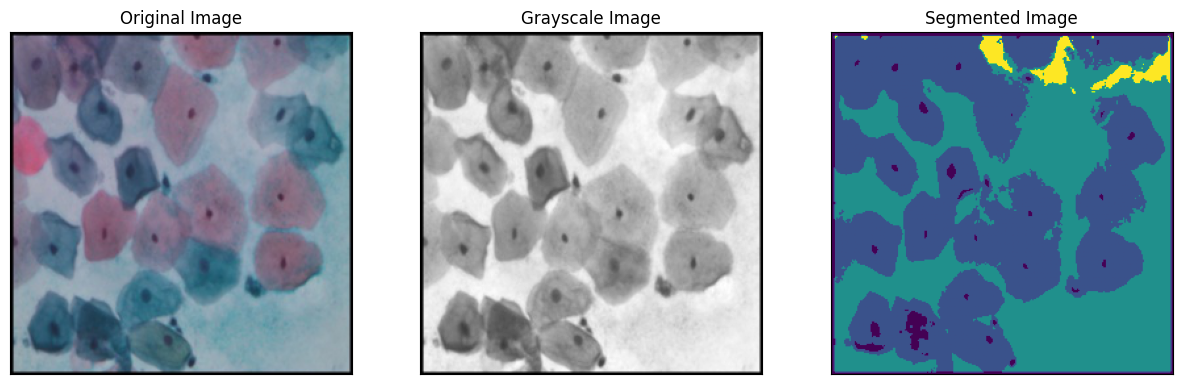

In [ ]:
def region_segment(img):
  g=region(img)
  plt.figure(figsize=(15,5))
  titles = ['Original Image','Grayscale Image',"Segmented Image"]
  plt.subplot(1,3,1),plt.imshow(img)
  plt.title(titles[0]), plt.xticks([]), plt.yticks([])
  plt.subplot(1,3,2),plt.imshow(rgb2gray(img),'gray')
  plt.title(titles[1]), plt.xticks([]), plt.yticks([])
  plt.subplot(1,3,3),plt.imshow(g)
  plt.title(titles[2]), plt.xticks([]), plt.yticks([])

region_segment(img)

In [ ]:
def FormatDataset(dataset_src, dataset_dest, classes):
    new_complete_dest = [os.path.join(dataset_dest, cls) for cls in classes]
    complete_src = [ dataset_src + "/" + cls for cls in classes]
    for (dest1) in (new_complete_dest):
        os.makedirs(dest1)
    #Formatting Segmented Images
    for (src, new_dest) in zip(complete_src, new_complete_dest):
      for file in os.listdir(src):
        filename, file_ext = os.path.splitext(file)
        img_des = os.path.join(new_dest, filename + '.jpg')
        img = cv2.imread(os.path.join(src, file))
        simg = region(img)
        plt.imshow(simg)
        plt.axis("off")
        plt.savefig(img_des, bbox_inches='tight')

#Source location for dataset
src = './sample_data/CervicalCancer'
#Destination location for dataset
dest = './sample_data/Segmented'
#Image classes
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]
#Formatting dataset
FormatDataset(src, dest, classes)

### Split the segmented data into training, testing and validation

In [ ]:
def TrainTestValSplit(root_dir, classes_dir, val_ratio = 0.1, test_ratio = 0.1):
    for cls in classes_dir:
        #Creating separate folders
        os.makedirs('sample_data/train/' + cls)
        os.makedirs('sample_data/test/' + cls)
        os.makedirs('sample_data/val/' + cls)
        
        src = os.path.join(root_dir, cls)

        #Spliting the image files in the given ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* (1 - (val_ratio + test_ratio))), int(len(allFileNames)* (1 - test_ratio))])

        train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
        test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]
        val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]

        #To display the split details
        print(cls,':')
        print('Total Images: ', len(allFileNames))
        print('Training: ', len(train_FileNames))
        print('Testing: ', len(test_FileNames))
        print('Validation: ', len(val_FileNames))
        
        for name in train_FileNames:
            shutil.copy(name, 'sample_data/train/' + cls)
        for name in test_FileNames:
            shutil.copy(name, 'sample_data/test/' + cls)
        for name in val_FileNames:
            shutil.copy(name, 'sample_data/val/' + cls)

        print()

root_dir = "./sample_data/Segmented"
classes = ["Dyskeratotic","Koilocytotic","Metaplastic","Parabasal","Superficial-Intermediate"]
TrainTestValSplit(root_dir, classes)

In [ ]:
train_dir = "sample_data/train/"
test_dir = "sample_data/test/"
val_dir = "sample_data/val/"

#Rescaling
train = ImageDataGenerator(zoom_range = 0.2, shear_range = 0.2, rescale = 1./255, horizontal_flip=True)
test = ImageDataGenerator(rescale = 1./255)
val = ImageDataGenerator(rescale = 1./255)

#Transfer the data from directories to batches
train_data = train.flow_from_directory(directory = train_dir,
                                               batch_size= 32,
                                               target_size= (256,256),
                                               class_mode = "categorical")

train_data.class_indices

Found 6121 images belonging to 5 classes.


{'Dyskeratotic': 0,
 'Koilocytotic': 1,
 'Metaplastic': 2,
 'Parabasal': 3,
 'Superficial-Intermediate': 4}

In [ ]:
test_data = test.flow_from_directory(directory = test_dir,
                                               batch_size = 32,
                                               target_size = (256,256),
                                               class_mode = "categorical")

val_data = val.flow_from_directory(directory = val_dir,
                                               batch_size = 32,
                                               target_size = (256,256),
                                               class_mode = "categorical")

Found 768 images belonging to 5 classes.
Found 766 images belonging to 5 classes.


#### Using ResNet50 Model

In [ ]:
base_model = ResNet50(input_shape=(256,256,3),
                      weights='imagenet',
                      include_top=False,)

for layer in base_model.layers:
       layer.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
model_resnet = Sequential()
model_resnet.add(base_model)
model_resnet.add(layers.Dense(64))
model_resnet.add(BatchNormalization())
model_resnet.add(layers.Dropout(0.25))
model_resnet.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_resnet.add(BatchNormalization())
model_resnet.add(layers.Flatten())
model_resnet.add(layers.Dropout(0.5))
model_resnet.add(layers.Dense(5, activation='softmax'))

In [ ]:
model_resnet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 dense (Dense)               (None, 8, 8, 64)          131136    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 64)         256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 8, 8, 64)          0         
                                                                 
 dense_1 (Dense)             (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                        

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_resnet_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
resnet = model_resnet.fit(
    train_data, 
    steps_per_epoch = len(train_data), 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = len(val_data),
    callbacks = call_back 
    )

Epoch 1/20
192/192 [==============================] - 137s 633ms/step - loss: 2.5344 - accuracy: 0.2253 - precision: 0.2321 - recall: 0.1505 - val_loss: 2.0751 - val_accuracy: 0.2820 - val_precision: 0.2820 - val_recall: 0.2820
Epoch 2/20
192/192 [==============================] - 104s 544ms/step - loss: 2.0422 - accuracy: 0.2384 - precision: 0.2421 - recall: 0.1113 - val_loss: 1.7940 - val_accuracy: 0.2493 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
192/192 [==============================] - 103s 537ms/step - loss: 1.8410 - accuracy: 0.2622 - precision: 0.2814 - recall: 0.0923 - val_loss: 1.7631 - val_accuracy: 0.2363 - val_precision: 0.2974 - val_recall: 0.1619
Epoch 4/20
192/192 [==============================] - 102s 529ms/step - loss: 1.7139 - accuracy: 0.2833 - precision: 0.3364 - recall: 0.0768 - val_loss: 1.6313 - val_accuracy: 0.2911 - val_precision: 0.4615 - val_recall: 0.0157
Epoch 5/20
192/192 [==============================] - 104s 541ms/step - loss: 1.

In [ ]:
#Loading the best fit model
resnet_model = load_model("./oc_resnet_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_resnet = resnet_model.evaluate_generator(generator= test_data)[1]
precision_resnet = resnet_model.evaluate_generator(generator= test_data)[2]
recall_resnet = resnet_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_resnet*100} %")
print(f"Precision = {precision_resnet*100} %")
print(f"Recall = {recall_resnet*100} %")

<ipython-input-37-23de1284d58a>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_resnet = resnet_model.evaluate_generator(generator= test_data)[1]
<ipython-input-37-23de1284d58a>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_resnet = resnet_model.evaluate_generator(generator= test_data)[2]
<ipython-input-37-23de1284d58a>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_resnet = resnet_model.evaluate_generator(generator= test_data)[3]


Accuracy = 34.63541567325592 %
Precision = 59.090906381607056 %
Recall = 5.078125 %


In [ ]:
results_df = pd.DataFrame(data=[["ResNet50", (accuracy_resnet*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df

Model  Testing Accuracy %
0  ResNet50           34.635416

#### Using VGG16 Model

In [ ]:
model_VGG = VGG16(
    input_shape = (256,256,3),
    weights='imagenet',
    include_top = False
    )

for layer in model_VGG.layers:
       layer.trainable = False

In [ ]:
#Applying L2 Regularization with Batch Normalization
vgg16 = Sequential()
vgg16.add(model_VGG)
vgg16.add(layers.Dense(64))
vgg16.add(BatchNormalization())
vgg16.add(layers.Dropout(0.25))
vgg16.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
vgg16.add(BatchNormalization())
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.5))
vgg16.add(layers.Dense(5, activation='softmax'))

In [ ]:
vgg16.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

vgg16.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 dense_12 (Dense)            (None, 8, 8, 64)          32832     
                                                                 
 batch_normalization_8 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 dense_13 (Dense)            (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_9 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                      

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_vgg_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
vgg = vgg16.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/20
191/191 [==============================] - 108s 548ms/step - loss: 2.3240 - accuracy: 0.3643 - precision: 0.3795 - recall: 0.3247 - val_loss: 1.5603 - val_accuracy: 0.4579 - val_precision: 0.5009 - val_recall: 0.3913
Epoch 2/20
191/191 [==============================] - 102s 532ms/step - loss: 1.8528 - accuracy: 0.4462 - precision: 0.4707 - recall: 0.3978 - val_loss: 1.6315 - val_accuracy: 0.4837 - val_precision: 0.5207 - val_recall: 0.4620
Epoch 3/20
191/191 [==============================] - 102s 533ms/step - loss: 1.5786 - accuracy: 0.4825 - precision: 0.5169 - recall: 0.4250 - val_loss: 1.2957 - val_accuracy: 0.5435 - val_precision: 0.5914 - val_recall: 0.4660
Epoch 4/20
191/191 [==============================] - 103s 538ms/step - loss: 1.3554 - accuracy: 0.5201 - precision: 0.5709 - recall: 0.4477 - val_loss: 1.1701 - val_accuracy: 0.5802 - val_precision: 0.6205 - val_recall: 0.4932
Epoch 5/20
191/191 [==============================] - 119s 623ms/step - loss: 1.2193 - a

In [ ]:
#Loading the best fit model
modelVGG = load_model("./oc_vgg_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_vgg = modelVGG.evaluate_generator(generator= test_data)[1]
precision_vgg = modelVGG.evaluate_generator(generator= test_data)[2]
recall_vgg = modelVGG.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_vgg*100} %")
print(f"Precision = {precision_vgg*100} %")
print(f"Recall = {recall_vgg*100} %")

<ipython-input-90-75803743878b>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_vgg = modelVGG.evaluate_generator(generator= test_data)[1]
<ipython-input-90-75803743878b>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_vgg = modelVGG.evaluate_generator(generator= test_data)[2]
<ipython-input-90-75803743878b>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_vgg = modelVGG.evaluate_generator(generator= test_data)[3]


Accuracy = 60.02604365348816 %
Precision = 66.21392369270325 %
Recall = 50.78125 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["VGG16", (accuracy_vgg*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0  ResNet50           34.635416
1     VGG16           60.026044

#### Using VGG19 Model

In [ ]:
model_VGG = VGG19(
    input_shape = (256,256,3),
    weights='imagenet',
    include_top = False
    )

for layer in model_VGG.layers:
       layer.trainable = False

In [ ]:
#Applying L2 Regularization with Batch Normalization
vgg19 = Sequential()
vgg19.add(model_VGG)
vgg19.add(layers.Dense(64))
vgg19.add(BatchNormalization())
vgg19.add(layers.Dropout(0.25))
vgg19.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
vgg19.add(BatchNormalization())
vgg19.add(layers.Flatten())
vgg19.add(layers.Dropout(0.5))
vgg19.add(layers.Dense(5, activation='softmax'))

In [ ]:
vgg19.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

vgg19.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 dense_15 (Dense)            (None, 8, 8, 64)          32832     
                                                                 
 batch_normalization_10 (Bat  (None, 8, 8, 64)         256       
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 dense_16 (Dense)            (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_11 (Bat  (None, 8, 8, 64)         256       
 chNormalization)                                     

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_vgg19_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
vgg = vgg19.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/20
191/191 [==============================] - 113s 576ms/step - loss: 2.3574 - accuracy: 0.3450 - precision: 0.3616 - recall: 0.3050 - val_loss: 2.4846 - val_accuracy: 0.2772 - val_precision: 0.2713 - val_recall: 0.2337
Epoch 2/20
191/191 [==============================] - 106s 554ms/step - loss: 1.9395 - accuracy: 0.4204 - precision: 0.4459 - recall: 0.3697 - val_loss: 2.1755 - val_accuracy: 0.3927 - val_precision: 0.3966 - val_recall: 0.3519
Epoch 3/20
191/191 [==============================] - 106s 554ms/step - loss: 1.6396 - accuracy: 0.4529 - precision: 0.4886 - recall: 0.3873 - val_loss: 1.2803 - val_accuracy: 0.5380 - val_precision: 0.5917 - val_recall: 0.4429
Epoch 4/20
191/191 [==============================] - 107s 557ms/step - loss: 1.4178 - accuracy: 0.4819 - precision: 0.5289 - recall: 0.3943 - val_loss: 1.4516 - val_accuracy: 0.4810 - val_precision: 0.5330 - val_recall: 0.3845
Epoch 5/20
191/191 [==============================] - 107s 559ms/step - loss: 1.2887 - a

In [ ]:
#Loading the best fit model
modelVGG19 = load_model("./oc_vgg19_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[1]
precision_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[2]
recall_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_vgg19*100} %")
print(f"Precision = {precision_vgg19*100} %")
print(f"Recall = {recall_vgg19*100} %")

<ipython-input-97-dd3cb86ce2c9>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[1]
<ipython-input-97-dd3cb86ce2c9>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[2]
<ipython-input-97-dd3cb86ce2c9>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_vgg19 = modelVGG19.evaluate_generator(generator= test_data)[3]


Accuracy = 56.77083134651184 %
Precision = 66.45962595939636 %
Recall = 41.796875 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["VGG19", (accuracy_vgg19*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0  ResNet50           34.635416
1     VGG16           60.026044
2     VGG19           56.770831

#### Using DenseNet121 Model

In [ ]:
model_densenet121 = DenseNet121(
    input_shape = (256,256,3),
    weights='imagenet',
    include_top = False
    )

for layer in model_densenet121.layers:
       layer.trainable = False

In [ ]:
#Applying L2 Regularization with Batch Normalization
densenet121 = tf.keras.Sequential()
densenet121.add(model_densenet121)
densenet121.add(layers.Dense(64))
densenet121.add(BatchNormalization())
densenet121.add(layers.Dropout(0.25))
densenet121.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
densenet121.add(BatchNormalization())
densenet121.add(layers.Flatten())
densenet121.add(layers.Dropout(0.5))
densenet121.add(layers.Dense(5, activation='softmax'))

In [ ]:
densenet121.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

densenet121.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 dense_18 (Dense)            (None, 8, 8, 64)          65600     
                                                                 
 batch_normalization_12 (Bat  (None, 8, 8, 64)         256       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 dense_19 (Dense)            (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_13 (Bat  (None, 8, 8, 64)         256       
 chNormalization)                                     

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_densenet121_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
densenet = densenet121.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/20
191/191 [==============================] - 112s 539ms/step - loss: 2.3534 - accuracy: 0.3687 - precision: 0.3863 - recall: 0.3248 - val_loss: 2.3372 - val_accuracy: 0.4076 - val_precision: 0.4248 - val_recall: 0.3764
Epoch 2/20
191/191 [==============================] - 100s 526ms/step - loss: 1.7549 - accuracy: 0.4781 - precision: 0.5017 - recall: 0.4326 - val_loss: 1.2762 - val_accuracy: 0.5217 - val_precision: 0.5664 - val_recall: 0.4579
Epoch 3/20
191/191 [==============================] - 97s 508ms/step - loss: 1.5228 - accuracy: 0.5211 - precision: 0.5542 - recall: 0.4699 - val_loss: 1.2274 - val_accuracy: 0.5761 - val_precision: 0.6213 - val_recall: 0.5149
Epoch 4/20
191/191 [==============================] - 96s 504ms/step - loss: 1.3168 - accuracy: 0.5464 - precision: 0.5895 - recall: 0.4884 - val_loss: 1.1513 - val_accuracy: 0.5802 - val_precision: 0.6260 - val_recall: 0.5231
Epoch 5/20
191/191 [==============================] - 98s 514ms/step - loss: 1.1858 - accu

In [ ]:
#Loading the best fit model
modeldensenet121 = load_model("./oc_densenet121_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[1]
precision_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[2]
recall_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_densenet121*100} %")
print(f"Precision = {precision_densenet121*100} %")
print(f"Recall = {recall_densenet121*100} %")

<ipython-input-104-53625a68bcce>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[1]
<ipython-input-104-53625a68bcce>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[2]
<ipython-input-104-53625a68bcce>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_densenet121 = modeldensenet121.evaluate_generator(generator= test_data)[3]


Accuracy = 64.32291865348816 %
Precision = 71.67235612869263 %
Recall = 54.6875 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["DenseNet121", (accuracy_densenet121*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           34.635416
1        VGG16           60.026044
2        VGG19           56.770831
3  DenseNet121           64.322919

#### Using DenseNet201 Model

In [ ]:
model_densenet = DenseNet201(
    input_shape = (256,256,3),
    weights='imagenet',
    include_top = False
    )

for layer in model_densenet.layers:
       layer.trainable = False

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
densenet201 = tf.keras.Sequential()
densenet201.add(model_densenet)
densenet201.add(layers.Dense(64))
densenet201.add(BatchNormalization())
densenet201.add(layers.Dropout(0.25))
densenet201.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
densenet201.add(BatchNormalization())
densenet201.add(layers.Flatten())
densenet201.add(layers.Dropout(0.5))
densenet201.add(layers.Dense(5, activation='softmax'))

In [ ]:
densenet201.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    metrics=['accuracy', 'Precision', 'Recall']
)

densenet201.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 dense (Dense)               (None, 8, 8, 64)          122944    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 64)         256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 8, 8, 64)          0         
                                                                 
 dense_1 (Dense)             (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                        

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_densenet_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [ mc ];

In [ ]:
#Fitting the model
densenet = densenet201.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks=call_back
)

Epoch 1/20
191/191 [==============================] - 136s 602ms/step - loss: 2.2985 - accuracy: 0.3736 - precision: 0.3919 - recall: 0.3332 - val_loss: 2.2662 - val_accuracy: 0.4443 - val_precision: 0.4480 - val_recall: 0.4212
Epoch 2/20
191/191 [==============================] - 105s 551ms/step - loss: 1.7747 - accuracy: 0.4723 - precision: 0.4944 - recall: 0.4278 - val_loss: 1.4632 - val_accuracy: 0.5326 - val_precision: 0.5667 - val_recall: 0.4905
Epoch 3/20
191/191 [==============================] - 106s 555ms/step - loss: 1.4465 - accuracy: 0.5333 - precision: 0.5646 - recall: 0.4823 - val_loss: 1.1299 - val_accuracy: 0.5856 - val_precision: 0.6468 - val_recall: 0.5149
Epoch 4/20
191/191 [==============================] - 107s 559ms/step - loss: 1.2574 - accuracy: 0.5661 - precision: 0.6044 - recall: 0.5062 - val_loss: 1.3854 - val_accuracy: 0.5272 - val_precision: 0.5745 - val_recall: 0.4769
Epoch 5/20
191/191 [==============================] - 106s 555ms/step - loss: 1.1302 - a

In [ ]:
#Loading the best fit model
modeldensenet = load_model("./oc_densenet_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_densenet = modeldensenet.evaluate_generator(generator= test_data)[1]
precision_densenet = modeldensenet.evaluate_generator(generator= test_data)[2]
recall_densenet = modeldensenet.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_densenet*100} %")
print(f"Precision = {precision_densenet*100} %")
print(f"Recall = {recall_densenet*100} %")

<ipython-input-12-d419c4f69c01>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_densenet = modeldensenet.evaluate_generator(generator= test_data)[1]
<ipython-input-12-d419c4f69c01>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_densenet = modeldensenet.evaluate_generator(generator= test_data)[2]
<ipython-input-12-d419c4f69c01>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_densenet = modeldensenet.evaluate_generator(generator= test_data)[3]


Accuracy = 66.27604365348816 %
Precision = 71.17834687232971 %
Recall = 58.203125 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["DenseNet201", (accuracy_densenet*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           34.635416
1        VGG16           60.026044
2        VGG19           56.770831
3  DenseNet121           64.322919
4  DenseNet201           66.276044

#### Using InceptionV3 Model

In [ ]:
input_tensor = Input(shape=(256,256,3))
bn = BatchNormalization()(input_tensor)
base_model = InceptionV3(input_shape = (256,256,3),
                         weights='imagenet',
                         include_top = False,)

for layer in base_model.layers:
       layer.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
x = base_model(bn)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer=l2(2e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(5, activation='softmax')(x)

In [ ]:
model_incep = tf.keras.models.Model(input_tensor, x)

model_incep.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.002), 
                    loss = 'categorical_crossentropy', 
                    metrics = ['accuracy', 'Precision', 'Recall'])

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_inception_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    );
call_back = [mc];

In [ ]:
#Fitting the model
incep = model_incep.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/20
191/191 [==============================] - 132s 640ms/step - loss: 19.5175 - accuracy: 0.2774 - precision: 0.2628 - recall: 0.0698 - val_loss: 2.0119 - val_accuracy: 0.2840 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
191/191 [==============================] - 108s 565ms/step - loss: 2.2570 - accuracy: 0.2751 - precision: 0.1963 - recall: 0.0140 - val_loss: 3.2906 - val_accuracy: 0.1250 - val_precision: 0.1245 - val_recall: 0.1182
Epoch 3/20
191/191 [==============================] - 110s 575ms/step - loss: 1.8623 - accuracy: 0.2836 - precision: 0.2714 - recall: 0.0125 - val_loss: 1.6293 - val_accuracy: 0.2826 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
191/191 [==============================] - 112s 584ms/step - loss: 1.8857 - accuracy: 0.2810 - precision: 0.2629 - recall: 0.0076 - val_loss: 1.5835 - val_accuracy: 0.2880 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
191/191 [==============================] - 111s 581m

In [ ]:
#Loading the best fit model
inceptionv3_model = load_model("./oc_inception_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_incep = inceptionv3_model.evaluate_generator(generator= test_data)[1]
precision_incep = inceptionv3_model.evaluate_generator(generator= test_data)[2]
recall_incep = inceptionv3_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_incep*100} %")
print(f"Precision = {precision_incep*100} %")
print(f"Recall = {recall_incep*100} %")

<ipython-input-20-3fff43831671>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_incep = inceptionv3_model.evaluate_generator(generator= test_data)[1]
<ipython-input-20-3fff43831671>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_incep = inceptionv3_model.evaluate_generator(generator= test_data)[2]
<ipython-input-20-3fff43831671>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_incep = inceptionv3_model.evaluate_generator(generator= test_data)[3]


Accuracy = 28.25520932674408 %
Precision = 0.0 %
Recall = 0.0 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["InceptionV3", (accuracy_incep*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           34.635416
1        VGG16           60.026044
2        VGG19           56.770831
3  DenseNet121           64.322919
4  DenseNet201           66.276044
5  InceptionV3           28.255209

#### Using Xception Model

In [ ]:
base_model = Xception(input_shape=(256,256,3),
                      weights='imagenet',
                      include_top=False,)

for layer in base_model.layers[:-3]:
       layer.trainable = False

83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
#Applying L2 Regularization with Batch Normalization
model_xception = Sequential()
model_xception.add(base_model)
model_xception.add(layers.Dense(64))
model_xception.add(BatchNormalization())
model_xception.add(layers.Dropout(0.25))
model_xception.add(layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model_xception.add(BatchNormalization())
model_xception.add(layers.Flatten())
model_xception.add(layers.Dropout(0.5))
model_xception.add(layers.Dense(5, activation='softmax'))

In [ ]:
model_xception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model_xception.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 dense_5 (Dense)             (None, 8, 8, 64)          131136    
                                                                 
 batch_normalization_101 (Ba  (None, 8, 8, 64)         256       
 tchNormalization)                                               
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 dense_6 (Dense)             (None, 8, 8, 64)          4160      
                                                                 
 batch_normalization_102 (Ba  (None, 8, 8, 64)         256       
 tchNormalization)                                    

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_xception_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
xception = model_xception.fit(
    train_data, 
    steps_per_epoch = len(train_data), 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = len(val_data),
    callbacks = call_back 
    )

Epoch 1/20
192/192 [==============================] - 113s 560ms/step - loss: 2.4074 - accuracy: 0.3459 - precision: 0.3648 - recall: 0.2800 - val_loss: 1.8747 - val_accuracy: 0.4282 - val_precision: 0.4729 - val_recall: 0.3877
Epoch 2/20
192/192 [==============================] - 103s 536ms/step - loss: 1.9751 - accuracy: 0.4352 - precision: 0.4717 - recall: 0.3276 - val_loss: 1.1908 - val_accuracy: 0.5601 - val_precision: 0.6403 - val_recall: 0.4230
Epoch 3/20
192/192 [==============================] - 103s 535ms/step - loss: 1.6739 - accuracy: 0.4991 - precision: 0.5490 - recall: 0.3880 - val_loss: 1.2589 - val_accuracy: 0.5313 - val_precision: 0.5816 - val_recall: 0.4465
Epoch 4/20
192/192 [==============================] - 103s 534ms/step - loss: 1.4636 - accuracy: 0.5406 - precision: 0.6056 - recall: 0.4329 - val_loss: 1.2029 - val_accuracy: 0.5248 - val_precision: 0.6019 - val_recall: 0.4047
Epoch 5/20
192/192 [==============================] - 104s 540ms/step - loss: 1.2749 - a

In [ ]:
#Loading the best fit model
xception_model = load_model("./oc_xception_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_xception = xception_model.evaluate_generator(generator= test_data)[1]
precision_xception = xception_model.evaluate_generator(generator= test_data)[2]
recall_xception = xception_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_xception*100} %")
print(f"Precision = {precision_xception*100} %")
print(f"Recall = {recall_xception*100} %")

<ipython-input-27-e3a41b4e3296>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_xception = xception_model.evaluate_generator(generator= test_data)[1]
<ipython-input-27-e3a41b4e3296>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_xception = xception_model.evaluate_generator(generator= test_data)[2]
<ipython-input-27-e3a41b4e3296>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_xception = xception_model.evaluate_generator(generator= test_data)[3]


Accuracy = 70.18229365348816 %
Precision = 73.78917336463928 %
Recall = 67.44791865348816 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["Xception", (accuracy_xception*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           34.635416
1        VGG16           60.026044
2        VGG19           56.770831
3  DenseNet121           64.322919
4  DenseNet201           66.276044
5  InceptionV3           28.255209
6     Xception           70.182294

#### Using Custom CNN Model

In [ ]:
model=Sequential()

#convolution layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(256,256,3)))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#convolution layer
model.add(Conv2D(32,(3,3),activation='relu'))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#convolution layer
model.add(Conv2D(64,(3,3),activation='relu'))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#convolution layer
model.add(Conv2D(64,(3,3),activation='relu'))
#pooling layer
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

#global average pooling
model.add(GlobalAveragePooling2D())
#fully connected layer
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(BatchNormalization())

#o/p layer
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy', 'Precision', 'Recall'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_103 (Ba  (None, 127, 127, 32)     128       
 tchNormalization)                                               
                                                                 
 conv2d_99 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                      

In [ ]:
#Adding model check point callback
mc = ModelCheckpoint(
    filepath="./oc_custom_best_model.hdf5",
    verbose= 0,
    save_best_only= True
    )
call_back = [mc];

In [ ]:
#Fitting the model
custom = model.fit(
    train_data, 
    steps_per_epoch = len(train_data), 
    epochs = 20, 
    validation_data = val_data, 
    validation_steps = len(val_data),
    callbacks = call_back 
    )

Epoch 1/20
192/192 [==============================] - 97s 482ms/step - loss: 1.4251 - accuracy: 0.4264 - precision: 0.5487 - recall: 0.1768 - val_loss: 2.0090 - val_accuracy: 0.2376 - val_precision: 0.2348 - val_recall: 0.1514
Epoch 2/20
192/192 [==============================] - 93s 487ms/step - loss: 1.2580 - accuracy: 0.5012 - precision: 0.6255 - recall: 0.2835 - val_loss: 2.1337 - val_accuracy: 0.2937 - val_precision: 0.2939 - val_recall: 0.1332
Epoch 3/20
192/192 [==============================] - 92s 482ms/step - loss: 1.1760 - accuracy: 0.5468 - precision: 0.6566 - recall: 0.3596 - val_loss: 1.4429 - val_accuracy: 0.3916 - val_precision: 0.4401 - val_recall: 0.2206
Epoch 4/20
192/192 [==============================] - 93s 482ms/step - loss: 1.1116 - accuracy: 0.5785 - precision: 0.6790 - recall: 0.4115 - val_loss: 3.3203 - val_accuracy: 0.1736 - val_precision: 0.1691 - val_recall: 0.1527
Epoch 5/20
192/192 [==============================] - 93s 484ms/step - loss: 1.0259 - accura

In [ ]:
#Loading the best fit model
custom_model = load_model("./oc_custom_best_model.hdf5")

In [ ]:
#Checking the accuracy, precision and recall of the model
accuracy_custom = custom_model.evaluate_generator(generator= test_data)[1]
precision_custom = custom_model.evaluate_generator(generator= test_data)[2]
recall_custom = custom_model.evaluate_generator(generator= test_data)[3]
print(f"Accuracy = {accuracy_custom*100} %")
print(f"Precision = {precision_custom*100} %")
print(f"Recall = {recall_custom*100} %")

<ipython-input-33-42bba74b5eb6>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  accuracy_custom = custom_model.evaluate_generator(generator= test_data)[1]
<ipython-input-33-42bba74b5eb6>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  precision_custom = custom_model.evaluate_generator(generator= test_data)[2]
<ipython-input-33-42bba74b5eb6>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  recall_custom = custom_model.evaluate_generator(generator= test_data)[3]


Accuracy = 72.39583134651184 %
Precision = 75.78347325325012 %
Recall = 69.27083134651184 %


In [ ]:
results_df_2 = pd.DataFrame(data=[["Custom", (accuracy_custom*100)]], 
                          columns=['Model', 'Testing Accuracy %'])
results_df = pd.concat([results_df, results_df_2], ignore_index=True)
results_df

Model  Testing Accuracy %
0     ResNet50           34.635416
1        VGG16           60.026044
2        VGG19           56.770831
3  DenseNet121           64.322919
4  DenseNet201           66.276044
5  InceptionV3           28.255209
6     Xception           70.182294
7       Custom           72.395831

In [ ]:
lab=['ResNet50','VGG16','VGG19','DenseNet121','DenseNet201','InceptionV3','Xception','Custom']
withoutseg=[accuracy_resnet, accuracy_vgg, accuracy_vgg19, accuracy_densenet121, accuracy_densenet, accuracy_incep, accuracy_xception, accuracy_custom]
otsu=[0.3885267376899719,0.48370274901390076,0.4471968710422516,0.4576271176338196,0.50065189599990845,0.2816166877746582,0.5228161811828613,0.4028683304786682]
canny=[0.4302477240562439,0.53194260597229004,0.5241199731826782,0.5580182671546936,0.5462841987609863,0.3337679207324982,0.5893089771270752,0.5371577739715576]
region=[0.3463541567325592,0.6002604365348816,0.5677083134651184,0.6432291865348816,0.6627604365348816,0.2825520932674408,0.7018229365348816,0.7239583134651184]

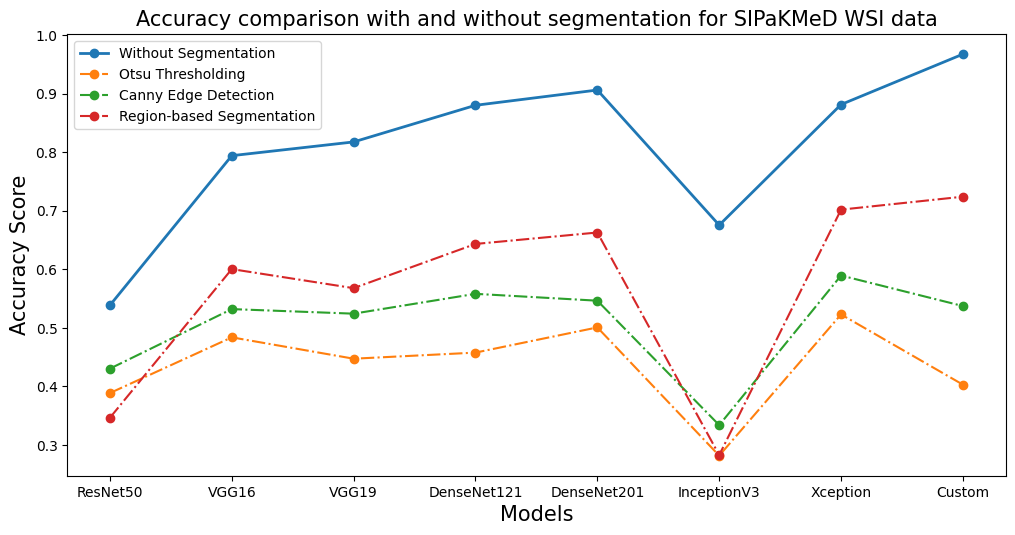

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(lab, withoutseg, label='Without Segmentation', marker='o', linestyle='-', linewidth=2)
plt.plot(lab, otsu, label='Otsu Thresholding', marker='o', linestyle='-.', linewidth=1.5)
plt.plot(lab, canny, label='Canny Edge Detection', marker='o', linestyle='-.', linewidth=1.5)
plt.plot(lab, region, label='Region-based Segmentation', marker='o', linestyle='-.', linewidth=1.5)
plt.tight_layout()
plt.legend()
plt.title('Accuracy comparison with and without segmentation for SIPaKMeD WSI data', fontsize=15)
plt.ylabel('Accuracy Score', fontsize=15)
plt.xlabel('Models', fontsize=15)
plt.show()

Inference: On comparing the results with and without segmentation as clearly shown in the line graph, the latter is better for this dataset.